# Convolutional Neural Network analizes results

## Importing packages

In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt
import time
import sympy as sp
from numba import jit

Using TensorFlow backend.


#### Convolutional Neural Networks

In [2]:
# Inisializes the Neural Network model 
from keras.models import Sequential

# This is to perform the convolution operation on a image, hence the 2D
from keras.layers import Conv2D

from keras.layers import MaxPooling2D

# Used for Flattening. Flattening is the process of converting all the resultant 2 dimensional arrays into a single long 
# continuous linear vector.
from keras.layers import Flatten

# Used to perform the full connection of the neural network
from keras.layers import Dense

# Stochastic gradient descent
from keras.optimizers import SGD

# Regularizer that utilizes Ridge regression
from keras.regularizers import l2

#### Loading and preprocessing packages

In [3]:
import IO
import Preprocess

## Loading and preprocessing data

In [68]:
raw_data = IO.loader("hmnist_8_8_RGB.csv")

data, raw_labels = Preprocess.create_label_data_split(raw_data, "label")
labels, legend = Preprocess.make_categorical(raw_labels, 7)
data = data.astype(np.float64)

# one-hot representation of labels
labels = np.argmax(labels, axis = 1)
labels = to_categorical(labels, num_classes = 7)

# Resizing data to (images,rows,col,RGB) = (10015,28,28,3)
resized_data = []
for i in range(10015):
    resized_data.append(data[i].reshape(8,8,3))

resized_data = np.array(resized_data)

# Splitting test, training and validation for both data and labels 
train_size = 0.6
test_size = 1 - train_size
train, test, train_labels, test_labels = train_test_split(resized_data, labels, train_size=train_size, test_size=test_size,
                                                         random_state = 7)

valid_size = 0.1
train_size = 1 - valid_size
train, valid, train_labels, valid_labels = train_test_split(train, train_labels, train_size=train_size, test_size=valid_size,
                                                           random_state = 15)

print("Number of training images: " , str(len(train)))
print("Number of validation images: " , str(len(valid)))
print("Number of test images: " , str(len(test)))

Number of training images:  5408
Number of validation images:  601
Number of test images:  4006


# Building a Convolutional Neural Network function

In [5]:
def create_convolutional_NN(data_shape, n_neurons_layers, n_categories, eta=0.1, lmbd=0.1, n_filters=32, filter_sizes=3, 
                            pool_size = (2, 2), conv_strides=1, act_func='relu', cost_function='categorical_crossentropy'):
    '''
    This function creates a Convolutional Neural Networks give the following parameters. 
    
    data_shape:       3D tensor with shape: (batch, steps, channels). Essentialy the input shape.
    n_neurons_layers: Number of neurons/nodes of in the hidden layers. If a vector, it will generate 
                      n hidden layers = len(n_neurons_layers), where each value in the vector denotes the number of neurons
                      in each hidden layer.
    n_categories:     Nunber of classification (output nodes). 
    eta:              Learning rate of the Stochastic gradient descent.
    lmbd:             L2 regularization parameter, also known as regularization strength.
    n_filters:        Number of filters.
    filter_sizes:     An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window.
                      Can be a single integer to specify the same value for all spatial dimensions. If a vector, 
                      it will generate n convolutional layers = size(filter_sizes), 
                      where each value in the vector denotes the filter size in each convolutional layer.
    pool_size:        integer or tuple of 2 integers, factors by which to downscale (vertical, horizontal). (2, 2) will 
                      halve the input in both spatial dimension. If only one integer is specified, the same window length 
                      will be used for both dimensions.
    conv_strides:     An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height 
                      and width. Can be a single integer to specify the same value for all spatial dimensions. For the 
                      convolutional layer.
    act_func:         Activation function to use. If you don't specify anything, no activation is applied 
                      (ie. "linear" activation: a(x) = x).
    cost_function:    String (name of objective function) or objective function. See losses. If the model has multiple 
                      outputs, you can use a different loss on each output by passing a dictionary or a list of losses. 
                      The loss value that will be minimized by the model will then be the sum of all individual losses.
    '''
    model = Sequential() # Inisializing Neural Network model
    
    ## Convolution and pooling layers
    # Adding a convolution layers
    if np.size(filter_sizes)>1:
        for conv_layer, filter_size in enumerate(filter_sizes):
            model.add(Conv2D(n_filters, filter_size, strides = conv_strides, input_shape = data_shape,
                             activation = act_func, kernel_regularizer=l2(lmbd)))
    else:
        conv_layer = 0
        model.add(Conv2D(n_filters, filter_sizes, strides = conv_strides, input_shape = data_shape, activation = act_func,
                         kernel_regularizer=l2(lmbd)))
    
    # adding the pooling layer
    model.add(MaxPooling2D(pool_size = pool_size))
    # Converting pooled image pixels (2D-array) to a one dimensional single vector.
    model.add(Flatten())
    
    ## Constructing hidden layers
    # Adding a fully-connected layer
    if np.size(n_neurons_layers)>1:
        for layer, n_neuron in enumerate(n_neurons_layers):
            model.add(Dense(units = n_neuron, activation='sigmoid', kernel_regularizer=l2(lmbd)))
    else:
        layer = 0
        model.add(Dense(units = n_neurons_layers, activation='sigmoid', kernel_regularizer=l2(lmbd)))
    
    ## Output layer
    model.add(Dense(units = n_categories, activation='softmax', kernel_regularizer=l2(lmbd)))
    
    ## Compiling model 
    sgd = SGD(lr=eta)
    model.compile(loss = cost_function, optimizer = sgd, metrics=['accuracy'])
    
    print("Convolutional Neural Network model with the following parameters:")
    print("------------------------------------------------------------------")
    print("Learning rate eta = ", eta)
    print("regularization strength lambda = ", lmbd)
    print("")
    print("Number of convolutional layers: ", (conv_layer+1))
    print("Number of filters in each convolutional layer: ", n_filters)
    print("Filter size in each convolutional layer: ", filter_sizes)
    print("")
    print("Number of hidden layers: ", (layer+1))
    print("Nunber of neurons in each hidden layer: ", n_neurons_layers)
    return model

#### Testing create_convolutional_NN function with singel or vector input of  filter_sizes (receptive_field) and n_neurons_layers

In [6]:
input_shape = (28,18,3)
n_filters = 15
n_categories = 7

receptive_field = [1, 2, 3, 4, 5, 6]
n_neurons_layers = [5, 10, 20, 40, 80, 100]

# singel value input for both filter_sizes (receptive_field) and n_neurons_layers
CNN_model_test = create_convolutional_NN(input_shape, n_neurons_layers[0], n_categories, n_filters = n_filters, 
                                    filter_sizes = receptive_field[5])
CNN_model_test.summary()

Convolutional Neural Network model with the following parameters:
------------------------------------------------------------------
Learning rate eta =  0.1
regularization strength lambda =  0.1

Number of convolutional layers:  1
Number of filters in each convolutional layer:  15
Filter size in each convolutional layer:  6

Number of hidden layers:  1
Nunber of neurons in each hidden layer:  5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 23, 13, 15)        1635      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 6, 15)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 990)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 4955      
_______

In [7]:
# vector input for both filter_sizes (receptive_field) and n_neurons_layers
CNN_model_test = create_convolutional_NN(input_shape, n_neurons_layers, n_categories, n_filters = n_filters, 
                                    filter_sizes = receptive_field)
CNN_model_test.summary()

Convolutional Neural Network model with the following parameters:
------------------------------------------------------------------
Learning rate eta =  0.1
regularization strength lambda =  0.1

Number of convolutional layers:  6
Number of filters in each convolutional layer:  15
Filter size in each convolutional layer:  [1, 2, 3, 4, 5, 6]

Number of hidden layers:  6
Nunber of neurons in each hidden layer:  [5, 10, 20, 40, 80, 100]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 18, 15)        60        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 17, 15)        915       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 15, 15)        2040      
_________________________________________________________________
conv2d_5 (Conv2D)            (Non

This is merely a test showing that one can change how many convolutional and hidden layes are set into the model, by sending more than one arguments at once (filter_sizes and n_neurons_layers).

## Evaluating the model preformance with different values of eta vs. lambda and n_neurons vs. n_filters

#### Defining plot functions

In [85]:
def plot_etaVSlambda(train_accuracy,test_accuracy):
    sns.set()
    sns.set(font_scale=2)
    
    fig, ax = plt.subplots(figsize = (10, 10))
    sns.heatmap(train_accuracy, vmin=0, vmax=1, annot=True, ax=ax, cmap="YlGnBu")
    ax.set_title("Training Accuracy")
    ax.set_ylabel("Learning rate $\eta$")
    ax.set_xlabel("Regularization parameter $\lambda$")
    ax.set_xticklabels(['0.00001', '0.0001', '0.001', '0.01', '1'])
    ax.set_yticklabels(['0.00001', '0.0001', '0.001', '0.01', '1', '2'])
    plt.show()

    fig, ax = plt.subplots(figsize = (10, 10))
    sns.heatmap(test_accuracy, vmin=0, vmax=1, annot=True, ax=ax, cmap="YlGnBu")
    ax.set_title("Test Accuracy")
    ax.set_ylabel("Learning rate $\eta$")
    ax.set_xlabel("Regularization parameter $\lambda$")
    ax.set_xticklabels(['0.00001', '0.0001', '0.001', '0.01', '1'])
    ax.set_yticklabels(['0.00001', '0.0001', '0.001', '0.01', '1', '2'])
    plt.show()

def plot_neuronsVSfilters(n_neurons,n_filters,train_accuracy,test_accuracy):
    sns.set()
    sns.set(font_scale=2)

    # convert axis values to to string labels
    x=[str(i) for i in n_filters]
    y=[str(i) for i in n_neurons]
    
    
    fig, ax = plt.subplots(figsize = (10, 10))
    sns.heatmap(train_accuracy, vmin=0, vmax=1, annot=True, ax=ax, cmap="YlGnBu")
    #ax.set_title("Training Accuracy")
    ax.set_ylabel("Number of neurons")
    ax.set_xlabel("Number of filters")
    ax.set_xticklabels(x)
    ax.set_yticklabels(y)
    plt.show()

    fig, ax = plt.subplots(figsize = (10, 10))
    sns.heatmap(test_accuracy, vmin=0, vmax=1, annot=True, ax=ax, cmap="YlGnBu")
    #ax.set_title("Test Accuracy")
    ax.set_ylabel("Number of neurons")
    ax.set_xlabel("Number of filters")
    ax.set_xticklabels(x)
    ax.set_yticklabels(y)
    plt.show()

### Evaluation: eta (learning rate) vs. lambda (regularization parameter)

In [79]:
epochs = 100
batch_size = 100
input_shape = np.shape(np.array(train)[1])
n_categories = labels.shape[1]
receptive_field = 3 

eta_values = [0.00001, 0.0001, 0.001, 0.01, 1, 2]
lambda_values = [0.00001, 0.0001, 0.001, 0.01, 1]
n_neuron_values = [5, 10, 20, 30, 40]
n_filter_values = [5, 10, 15, 20, 25]

In [80]:
# Here we use 20 neurons and 5 filters, since it is uncertain what is the best value conbination and to .

train_accuracy = np.zeros((len(eta_values), len(lambda_values)))
test_accuracy = np.zeros((len(eta_values), len(lambda_values)))


t1 = time.clock()
for i, eta in enumerate(eta_values):
    for j, lmbd in enumerate(lambda_values):
        # Creating the model
        CNN_model = create_convolutional_NN(input_shape, n_neuron_values[2], n_categories, eta=eta, lmbd=lmbd, 
                                            n_filters = 5, filter_sizes = receptive_field)
        
        # Fitting the model with the training data
        CNN_model.fit(train, train_labels, epochs = epochs, batch_size = batch_size, verbose = 1, 
                      validation_data = (valid, valid_labels))
        
        # Saving accuracy scores 
        train_accuracy[i][j] = CNN_model.evaluate(train, train_labels)[1]
        test_accuracy[i][j] = CNN_model.evaluate(test, test_labels)[1]
        
t2 = time.clock()
print("Total time needed to run this loops:", (t2-t1), "seconds")

Convolutional Neural Network model with the following parameters:
------------------------------------------------------------------
Learning rate eta =  1e-05
regularization strength lambda =  1e-05

Number of convolutional layers:  1
Number of filters in each convolutional layer:  5
Filter size in each convolutional layer:  3

Number of hidden layers:  1
Nunber of neurons in each hidden layer:  20
Train on 5408 samples, validate on 601 samples
Epoch 1/100
5408/5408 [==============================] - 8s 1ms/step - loss: 2.3814 - acc: 0.0418 - val_loss: 2.3639 - val_acc: 0.0449
Epoch 2/100
5408/5408 [==============================] - 1s 196us/step - loss: 2.3602 - acc: 0.0414 - val_loss: 2.3453 - val_acc: 0.0449
Epoch 3/100
5408/5408 [==============================] - 1s 198us/step - loss: 2.3451 - acc: 0.0414 - val_loss: 2.3316 - val_acc: 0.0449
Epoch 4/100
5408/5408 [==============================] - 1s 194us/step - loss: 2.3340 - acc: 0.0422 - val_loss: 2.3211 - val_acc: 0.0449
Epoc

Epoch 57/100
5408/5408 [==============================] - 1s 193us/step - loss: 2.0851 - acc: 0.0409 - val_loss: 2.0750 - val_acc: 0.0383
Epoch 58/100
5408/5408 [==============================] - 1s 188us/step - loss: 2.0809 - acc: 0.0411 - val_loss: 2.0706 - val_acc: 0.0399
Epoch 59/100
5408/5408 [==============================] - 1s 187us/step - loss: 2.0769 - acc: 0.0411 - val_loss: 2.0665 - val_acc: 0.0399
Epoch 60/100
5408/5408 [==============================] - 1s 199us/step - loss: 2.0731 - acc: 0.0416 - val_loss: 2.0629 - val_acc: 0.0383
Epoch 61/100
5408/5408 [==============================] - 1s 212us/step - loss: 2.0697 - acc: 0.0416 - val_loss: 2.0598 - val_acc: 0.0383
Epoch 62/100
5408/5408 [==============================] - 1s 229us/step - loss: 2.0664 - acc: 0.0412 - val_loss: 2.0568 - val_acc: 0.0383
Epoch 63/100
5408/5408 [==============================] - 1s 195us/step - loss: 2.0632 - acc: 0.0409 - val_loss: 2.0541 - val_acc: 0.0383
Epoch 64/100
5408/5408 [==========

5408/5408 [==============================] - 1s 203us/step - loss: 1.9148 - acc: 0.1119 - val_loss: 1.9126 - val_acc: 0.1065
Epoch 13/100
5408/5408 [==============================] - 1s 196us/step - loss: 1.9115 - acc: 0.1119 - val_loss: 1.9093 - val_acc: 0.1065
Epoch 14/100
5408/5408 [==============================] - 1s 202us/step - loss: 1.9084 - acc: 0.1119 - val_loss: 1.9062 - val_acc: 0.1065
Epoch 15/100
5408/5408 [==============================] - 1s 199us/step - loss: 1.9054 - acc: 0.1119 - val_loss: 1.9033 - val_acc: 0.1065
Epoch 16/100
5408/5408 [==============================] - 1s 203us/step - loss: 1.9025 - acc: 0.1119 - val_loss: 1.9004 - val_acc: 0.1065
Epoch 17/100
5408/5408 [==============================] - 1s 217us/step - loss: 1.8997 - acc: 0.1119 - val_loss: 1.8977 - val_acc: 0.1065
Epoch 18/100
5408/5408 [==============================] - 1s 230us/step - loss: 1.8970 - acc: 0.1119 - val_loss: 1.8949 - val_acc: 0.1065
Epoch 19/100
5408/5408 [=======================

5408/5408 [==============================] - 1s 200us/step - loss: 1.7694 - acc: 0.1119 - val_loss: 1.7678 - val_acc: 0.1065
Epoch 72/100
5408/5408 [==============================] - 1s 196us/step - loss: 1.7672 - acc: 0.1119 - val_loss: 1.7656 - val_acc: 0.1065
Epoch 73/100
5408/5408 [==============================] - 1s 214us/step - loss: 1.7651 - acc: 0.1119 - val_loss: 1.7634 - val_acc: 0.1065
Epoch 74/100
5408/5408 [==============================] - 1s 205us/step - loss: 1.7630 - acc: 0.1119 - val_loss: 1.7613 - val_acc: 0.1065
Epoch 75/100
5408/5408 [==============================] - 1s 194us/step - loss: 1.7608 - acc: 0.1119 - val_loss: 1.7591 - val_acc: 0.1065
Epoch 76/100
5408/5408 [==============================] - 1s 194us/step - loss: 1.7587 - acc: 0.1119 - val_loss: 1.7570 - val_acc: 0.1065
Epoch 77/100
5408/5408 [==============================] - 1s 197us/step - loss: 1.7565 - acc: 0.1119 - val_loss: 1.7548 - val_acc: 0.1065
Epoch 78/100
5408/5408 [=======================

Epoch 25/100
5408/5408 [==============================] - 1s 203us/step - loss: 1.6730 - acc: 0.6037 - val_loss: 1.6876 - val_acc: 0.6123
Epoch 26/100
5408/5408 [==============================] - 1s 207us/step - loss: 1.6681 - acc: 0.6082 - val_loss: 1.6837 - val_acc: 0.6156
Epoch 27/100
5408/5408 [==============================] - 1s 200us/step - loss: 1.6636 - acc: 0.6143 - val_loss: 1.6801 - val_acc: 0.6173
Epoch 28/100
5408/5408 [==============================] - 1s 199us/step - loss: 1.6595 - acc: 0.6183 - val_loss: 1.6767 - val_acc: 0.6173
Epoch 29/100
5408/5408 [==============================] - 1s 200us/step - loss: 1.6557 - acc: 0.6219 - val_loss: 1.6736 - val_acc: 0.6173
Epoch 30/100
5408/5408 [==============================] - 1s 202us/step - loss: 1.6521 - acc: 0.6259 - val_loss: 1.6707 - val_acc: 0.6206
Epoch 31/100
5408/5408 [==============================] - 1s 197us/step - loss: 1.6488 - acc: 0.6285 - val_loss: 1.6679 - val_acc: 0.6256
Epoch 32/100
5408/5408 [==========

5408/5408 [==============================] - 1s 177us/step - loss: 1.5495 - acc: 0.6616 - val_loss: 1.5718 - val_acc: 0.6489
Epoch 85/100
5408/5408 [==============================] - 1s 187us/step - loss: 1.5484 - acc: 0.6616 - val_loss: 1.5705 - val_acc: 0.6489
Epoch 86/100
5408/5408 [==============================] - 1s 178us/step - loss: 1.5472 - acc: 0.6620 - val_loss: 1.5691 - val_acc: 0.6489
Epoch 87/100
5408/5408 [==============================] - 1s 177us/step - loss: 1.5461 - acc: 0.6622 - val_loss: 1.5679 - val_acc: 0.6506
Epoch 88/100
5408/5408 [==============================] - 1s 175us/step - loss: 1.5451 - acc: 0.6620 - val_loss: 1.5668 - val_acc: 0.6506
Epoch 89/100
5408/5408 [==============================] - 1s 173us/step - loss: 1.5440 - acc: 0.6622 - val_loss: 1.5656 - val_acc: 0.6506
Epoch 90/100
5408/5408 [==============================] - ETA: 0s - loss: 1.5426 - acc: 0.662 - 1s 175us/step - loss: 1.5429 - acc: 0.6622 - val_loss: 1.5645 - val_acc: 0.6506
Epoch 91/

5408/5408 [==============================] - 1s 201us/step - loss: 2.9415 - acc: 0.1187 - val_loss: 2.9130 - val_acc: 0.1181
Epoch 39/100
5408/5408 [==============================] - 1s 199us/step - loss: 2.9357 - acc: 0.1183 - val_loss: 2.9072 - val_acc: 0.1181
Epoch 40/100
5408/5408 [==============================] - 1s 196us/step - loss: 2.9301 - acc: 0.1182 - val_loss: 2.9014 - val_acc: 0.11810s - loss: 2.9216 - acc
Epoch 41/100
5408/5408 [==============================] - 1s 190us/step - loss: 2.9245 - acc: 0.1176 - val_loss: 2.8958 - val_acc: 0.1181
Epoch 42/100
5408/5408 [==============================] - 1s 188us/step - loss: 2.9187 - acc: 0.1176 - val_loss: 2.8901 - val_acc: 0.1181
Epoch 43/100
5408/5408 [==============================] - 1s 184us/step - loss: 2.9129 - acc: 0.1174 - val_loss: 2.8844 - val_acc: 0.1181
Epoch 44/100
5408/5408 [==============================] - 1s 179us/step - loss: 2.9070 - acc: 0.1169 - val_loss: 2.8788 - val_acc: 0.1181
Epoch 45/100
5408/5408 [

5408/5408 [==============================] - 1s 185us/step - loss: 2.7101 - acc: 0.1154 - val_loss: 2.6804 - val_acc: 0.1148
Epoch 97/100
5408/5408 [==============================] - 1s 187us/step - loss: 2.7075 - acc: 0.1152 - val_loss: 2.6778 - val_acc: 0.1148
Epoch 98/100
5408/5408 [==============================] - 1s 184us/step - loss: 2.7048 - acc: 0.1152 - val_loss: 2.6752 - val_acc: 0.1131
Epoch 99/100
5408/5408 [==============================] - 1s 177us/step - loss: 2.7022 - acc: 0.1152 - val_loss: 2.6727 - val_acc: 0.1131
Epoch 100/100
4006/4006 [==============================] - 1s 180us/step
Convolutional Neural Network model with the following parameters:
------------------------------------------------------------------
Learning rate eta =  1e-05
regularization strength lambda =  1

Number of convolutional layers:  1
Number of filters in each convolutional layer:  5
Filter size in each convolutional layer:  3

Number of hidden layers:  1
Nunber of neurons in each hidden 

5408/5408 [==============================] - 1s 181us/step - loss: 41.4519 - acc: 0.6557 - val_loss: 41.4263 - val_acc: 0.6489
Epoch 51/100
5408/5408 [==============================] - 1s 183us/step - loss: 41.3631 - acc: 0.6559 - val_loss: 41.3373 - val_acc: 0.6489
Epoch 52/100
5408/5408 [==============================] - 1s 186us/step - loss: 41.2746 - acc: 0.6563 - val_loss: 41.2486 - val_acc: 0.6489
Epoch 53/100
5408/5408 [==============================] - 1s 181us/step - loss: 41.1863 - acc: 0.6563 - val_loss: 41.1600 - val_acc: 0.6489
Epoch 54/100
5408/5408 [==============================] - 1s 182us/step - loss: 41.0983 - acc: 0.6566 - val_loss: 41.0717 - val_acc: 0.6489
Epoch 55/100
5408/5408 [==============================] - 1s 180us/step - loss: 41.0104 - acc: 0.6566 - val_loss: 40.9836 - val_acc: 0.6489
Epoch 56/100
5408/5408 [==============================] - 1s 181us/step - loss: 40.9227 - acc: 0.6566 - val_loss: 40.8955 - val_acc: 0.6489
Epoch 57/100
5408/5408 [=========

5408/5408 [==============================] - 1s 180us/step - loss: 1.9779 - acc: 0.0503 - val_loss: 1.9801 - val_acc: 0.0582
Epoch 5/100
5408/5408 [==============================] - 1s 179us/step - loss: 1.9496 - acc: 0.0503 - val_loss: 1.9524 - val_acc: 0.0582
Epoch 6/100
5408/5408 [==============================] - 1s 191us/step - loss: 1.9230 - acc: 0.0503 - val_loss: 1.9273 - val_acc: 0.0582
Epoch 7/100
5408/5408 [==============================] - 1s 181us/step - loss: 1.8981 - acc: 0.0503 - val_loss: 1.9039 - val_acc: 0.0582
Epoch 8/100
5408/5408 [==============================] - 1s 187us/step - loss: 1.8748 - acc: 0.0503 - val_loss: 1.8825 - val_acc: 0.0582
Epoch 9/100
5408/5408 [==============================] - 1s 185us/step - loss: 1.8529 - acc: 0.0503 - val_loss: 1.8621 - val_acc: 0.0582
Epoch 10/100
5408/5408 [==============================] - 1s 181us/step - loss: 1.8322 - acc: 0.0503 - val_loss: 1.8432 - val_acc: 0.0582
Epoch 11/100
5408/5408 [============================

5408/5408 [==============================] - 1s 181us/step - loss: 1.3944 - acc: 0.6686 - val_loss: 1.4248 - val_acc: 0.6572
Epoch 64/100
5408/5408 [==============================] - 1s 179us/step - loss: 1.3914 - acc: 0.6686 - val_loss: 1.4219 - val_acc: 0.6572
Epoch 65/100
5408/5408 [==============================] - 1s 181us/step - loss: 1.3885 - acc: 0.6686 - val_loss: 1.4191 - val_acc: 0.6572
Epoch 66/100
5408/5408 [==============================] - 1s 186us/step - loss: 1.3856 - acc: 0.6686 - val_loss: 1.4163 - val_acc: 0.6572
Epoch 67/100
5408/5408 [==============================] - 1s 209us/step - loss: 1.3828 - acc: 0.6686 - val_loss: 1.4136 - val_acc: 0.6572
Epoch 68/100
5408/5408 [==============================] - 1s 190us/step - loss: 1.3802 - acc: 0.6686 - val_loss: 1.4110 - val_acc: 0.6572
Epoch 69/100
5408/5408 [==============================] - 1s 192us/step - loss: 1.3775 - acc: 0.6686 - val_loss: 1.4084 - val_acc: 0.6572
Epoch 70/100
5408/5408 [=======================

Epoch 18/100
5408/5408 [==============================] - 1s 191us/step - loss: 1.6329 - acc: 0.6577 - val_loss: 1.6295 - val_acc: 0.6539
Epoch 19/100
5408/5408 [==============================] - 1s 182us/step - loss: 1.6208 - acc: 0.6581 - val_loss: 1.6181 - val_acc: 0.6522
Epoch 20/100
5408/5408 [==============================] - 1s 188us/step - loss: 1.6091 - acc: 0.6598 - val_loss: 1.6070 - val_acc: 0.6522
Epoch 21/100
5408/5408 [==============================] - 1s 192us/step - loss: 1.5978 - acc: 0.6605 - val_loss: 1.5961 - val_acc: 0.6522
Epoch 22/100
5408/5408 [==============================] - 1s 187us/step - loss: 1.5867 - acc: 0.6607 - val_loss: 1.5855 - val_acc: 0.6522
Epoch 23/100
5408/5408 [==============================] - 1s 187us/step - loss: 1.5759 - acc: 0.6607 - val_loss: 1.5752 - val_acc: 0.6522
Epoch 24/100
5408/5408 [==============================] - 1s 183us/step - loss: 1.5655 - acc: 0.6611 - val_loss: 1.5652 - val_acc: 0.6522
Epoch 25/100
5408/5408 [==========

Epoch 77/100
5408/5408 [==============================] - 1s 189us/step - loss: 1.2763 - acc: 0.6685 - val_loss: 1.2878 - val_acc: 0.6572
Epoch 78/100
5408/5408 [==============================] - 1s 190us/step - loss: 1.2739 - acc: 0.6685 - val_loss: 1.2857 - val_acc: 0.6572
Epoch 79/100
5408/5408 [==============================] - 1s 191us/step - loss: 1.2717 - acc: 0.6685 - val_loss: 1.2835 - val_acc: 0.6572
Epoch 80/100
5408/5408 [==============================] - 1s 196us/step - loss: 1.2695 - acc: 0.6685 - val_loss: 1.2815 - val_acc: 0.6572
Epoch 81/100
5408/5408 [==============================] - 1s 188us/step - loss: 1.2674 - acc: 0.6685 - val_loss: 1.2794 - val_acc: 0.6572
Epoch 82/100
5408/5408 [==============================] - 1s 192us/step - loss: 1.2653 - acc: 0.6685 - val_loss: 1.2775 - val_acc: 0.6572
Epoch 83/100
5408/5408 [==============================] - 1s 194us/step - loss: 1.2633 - acc: 0.6685 - val_loss: 1.2756 - val_acc: 0.6572
Epoch 84/100
5408/5408 [==========

5408/5408 [==============================] - 1s 229us/step - loss: 1.3008 - acc: 0.6686 - val_loss: 1.3359 - val_acc: 0.6572
Epoch 33/100
5408/5408 [==============================] - 1s 220us/step - loss: 1.2972 - acc: 0.6688 - val_loss: 1.3307 - val_acc: 0.6572
Epoch 34/100
5408/5408 [==============================] - 1s 221us/step - loss: 1.2937 - acc: 0.6685 - val_loss: 1.3284 - val_acc: 0.6572
Epoch 35/100
5408/5408 [==============================] - 1s 219us/step - loss: 1.2905 - acc: 0.6685 - val_loss: 1.3265 - val_acc: 0.6589
Epoch 36/100
5408/5408 [==============================] - 1s 226us/step - loss: 1.2875 - acc: 0.6692 - val_loss: 1.3248 - val_acc: 0.6572 0s - loss: 1.2
Epoch 37/100
5408/5408 [==============================] - 1s 213us/step - loss: 1.2842 - acc: 0.6688 - val_loss: 1.3212 - val_acc: 0.6572
Epoch 38/100
5408/5408 [==============================] - 1s 207us/step - loss: 1.2808 - acc: 0.6690 - val_loss: 1.3175 - val_acc: 0.6572
Epoch 39/100
5408/5408 [========

Epoch 91/100
5408/5408 [==============================] - 1s 207us/step - loss: 1.1818 - acc: 0.6685 - val_loss: 1.2295 - val_acc: 0.6572
Epoch 92/100
5408/5408 [==============================] - 1s 205us/step - loss: 1.1806 - acc: 0.6685 - val_loss: 1.2291 - val_acc: 0.6572
Epoch 93/100
5408/5408 [==============================] - 1s 214us/step - loss: 1.1797 - acc: 0.6685 - val_loss: 1.2286 - val_acc: 0.6572
Epoch 94/100
5408/5408 [==============================] - 1s 221us/step - loss: 1.1785 - acc: 0.6685 - val_loss: 1.2265 - val_acc: 0.6572
Epoch 95/100
5408/5408 [==============================] - 1s 224us/step - loss: 1.1776 - acc: 0.6685 - val_loss: 1.2245 - val_acc: 0.6572
Epoch 96/100
5408/5408 [==============================] - 1s 200us/step - loss: 1.1766 - acc: 0.6685 - val_loss: 1.2223 - val_acc: 0.6572
Epoch 97/100
5408/5408 [==============================] - 1s 206us/step - loss: 1.1758 - acc: 0.6685 - val_loss: 1.2230 - val_acc: 0.6572
Epoch 98/100
5408/5408 [==========

5408/5408 [==============================] - 1s 189us/step - loss: 1.7771 - acc: 0.6686 - val_loss: 1.7882 - val_acc: 0.6572
Epoch 47/100
5408/5408 [==============================] - 1s 192us/step - loss: 1.7733 - acc: 0.6686 - val_loss: 1.7845 - val_acc: 0.6572
Epoch 48/100
5408/5408 [==============================] - 1s 205us/step - loss: 1.7696 - acc: 0.6686 - val_loss: 1.7809 - val_acc: 0.6572
Epoch 49/100
5408/5408 [==============================] - 1s 187us/step - loss: 1.7660 - acc: 0.6686 - val_loss: 1.7774 - val_acc: 0.6572
Epoch 50/100
5408/5408 [==============================] - 1s 192us/step - loss: 1.7625 - acc: 0.6686 - val_loss: 1.7740 - val_acc: 0.6572
Epoch 51/100
5408/5408 [==============================] - 1s 197us/step - loss: 1.7590 - acc: 0.6686 - val_loss: 1.7707 - val_acc: 0.6572
Epoch 52/100
5408/5408 [==============================] - 1s 187us/step - loss: 1.7556 - acc: 0.6686 - val_loss: 1.7673 - val_acc: 0.6572
Epoch 53/100
5408/5408 [=======================

5408/5408 [==============================] - 8s 2ms/step - loss: 42.6933 - acc: 0.0501 - val_loss: 42.2026 - val_acc: 0.0582
Epoch 2/100
5408/5408 [==============================] - 1s 192us/step - loss: 41.7142 - acc: 0.0525 - val_loss: 41.2327 - val_acc: 0.1381
Epoch 3/100
5408/5408 [==============================] - 1s 189us/step - loss: 40.7702 - acc: 0.2006 - val_loss: 40.3223 - val_acc: 0.2047
Epoch 4/100
5408/5408 [==============================] - 1s 187us/step - loss: 39.8849 - acc: 0.2777 - val_loss: 39.4570 - val_acc: 0.2812
Epoch 5/100
5408/5408 [==============================] - 1s 188us/step - loss: 39.0333 - acc: 0.3539 - val_loss: 38.6154 - val_acc: 0.3544
Epoch 6/100
5408/5408 [==============================] - 1s 188us/step - loss: 38.2026 - acc: 0.4135 - val_loss: 37.7966 - val_acc: 0.4143
Epoch 7/100
5408/5408 [==============================] - 1s 185us/step - loss: 37.3911 - acc: 0.4604 - val_loss: 36.9965 - val_acc: 0.4642
Epoch 8/100
5408/5408 [==================

5408/5408 [==============================] - 1s 190us/step - loss: 12.8277 - acc: 0.6686 - val_loss: 12.7147 - val_acc: 0.6572
Epoch 60/100
5408/5408 [==============================] - 1s 189us/step - loss: 12.5794 - acc: 0.6686 - val_loss: 12.4691 - val_acc: 0.6572
Epoch 61/100
5408/5408 [==============================] - 1s 187us/step - loss: 12.3365 - acc: 0.6686 - val_loss: 12.2289 - val_acc: 0.6572
Epoch 62/100
5408/5408 [==============================] - 1s 187us/step - loss: 12.0988 - acc: 0.6686 - val_loss: 11.9940 - val_acc: 0.6572
Epoch 63/100
5408/5408 [==============================] - 1s 183us/step - loss: 11.8664 - acc: 0.6686 - val_loss: 11.7642 - val_acc: 0.6572
Epoch 64/100
5408/5408 [==============================] - 1s 200us/step - loss: 11.6391 - acc: 0.6686 - val_loss: 11.5394 - val_acc: 0.6572
Epoch 65/100
5408/5408 [==============================] - 1s 210us/step - loss: 11.4167 - acc: 0.6686 - val_loss: 11.3195 - val_acc: 0.6572
Epoch 66/100
5408/5408 [=========

5408/5408 [==============================] - 1s 189us/step - loss: 1.2454 - acc: 0.6686 - val_loss: 1.2759 - val_acc: 0.6572
Epoch 15/100
5408/5408 [==============================] - 1s 190us/step - loss: 1.2369 - acc: 0.6686 - val_loss: 1.2687 - val_acc: 0.6572
Epoch 16/100
5408/5408 [==============================] - 1s 186us/step - loss: 1.2297 - acc: 0.6686 - val_loss: 1.2610 - val_acc: 0.6572
Epoch 17/100
5408/5408 [==============================] - 1s 189us/step - loss: 1.2233 - acc: 0.6686 - val_loss: 1.2546 - val_acc: 0.6572
Epoch 18/100
5408/5408 [==============================] - 1s 189us/step - loss: 1.2174 - acc: 0.6686 - val_loss: 1.2470 - val_acc: 0.6572
Epoch 19/100
5408/5408 [==============================] - 1s 192us/step - loss: 1.2122 - acc: 0.6686 - val_loss: 1.2413 - val_acc: 0.6572
Epoch 20/100
5408/5408 [==============================] - 1s 195us/step - loss: 1.2059 - acc: 0.6686 - val_loss: 1.2252 - val_acc: 0.6572
Epoch 21/100
5408/5408 [=======================

5408/5408 [==============================] - 1s 230us/step - loss: 1.0863 - acc: 0.6686 - val_loss: 1.0947 - val_acc: 0.6572
Epoch 74/100
5408/5408 [==============================] - 1s 203us/step - loss: 1.0852 - acc: 0.6686 - val_loss: 1.1007 - val_acc: 0.6572
Epoch 75/100
5408/5408 [==============================] - 1s 205us/step - loss: 1.0843 - acc: 0.6686 - val_loss: 1.1003 - val_acc: 0.6572
Epoch 76/100
5408/5408 [==============================] - 1s 222us/step - loss: 1.0841 - acc: 0.6686 - val_loss: 1.0926 - val_acc: 0.6572
Epoch 77/100
5408/5408 [==============================] - 1s 203us/step - loss: 1.0832 - acc: 0.6686 - val_loss: 1.0928 - val_acc: 0.6572
Epoch 78/100
5408/5408 [==============================] - 1s 203us/step - loss: 1.0829 - acc: 0.6686 - val_loss: 1.0961 - val_acc: 0.6572
Epoch 79/100
5408/5408 [==============================] - 1s 205us/step - loss: 1.0819 - acc: 0.6686 - val_loss: 1.0927 - val_acc: 0.6572
Epoch 80/100
5408/5408 [=======================

5408/5408 [==============================] - 1s 194us/step - loss: 1.1467 - acc: 0.6686 - val_loss: 1.1698 - val_acc: 0.6572
Epoch 28/100
5408/5408 [==============================] - 1s 185us/step - loss: 1.1454 - acc: 0.6686 - val_loss: 1.1681 - val_acc: 0.6572
Epoch 29/100
5408/5408 [==============================] - 1s 186us/step - loss: 1.1442 - acc: 0.6686 - val_loss: 1.1665 - val_acc: 0.6572
Epoch 30/100
5408/5408 [==============================] - 1s 182us/step - loss: 1.1432 - acc: 0.6686 - val_loss: 1.1649 - val_acc: 0.6572
Epoch 31/100
5408/5408 [==============================] - 1s 183us/step - loss: 1.1421 - acc: 0.6686 - val_loss: 1.1635 - val_acc: 0.6572
Epoch 32/100
5408/5408 [==============================] - 1s 180us/step - loss: 1.1412 - acc: 0.6686 - val_loss: 1.1622 - val_acc: 0.6572
Epoch 33/100
5408/5408 [==============================] - 1s 190us/step - loss: 1.1402 - acc: 0.6686 - val_loss: 1.1608 - val_acc: 0.6572
Epoch 34/100
5408/5408 [=======================

5408/5408 [==============================] - 1s 183us/step - loss: 1.1194 - acc: 0.6686 - val_loss: 1.1313 - val_acc: 0.6572
Epoch 87/100
5408/5408 [==============================] - 1s 187us/step - loss: 1.1192 - acc: 0.6686 - val_loss: 1.1311 - val_acc: 0.6572
Epoch 88/100
5408/5408 [==============================] - 1s 187us/step - loss: 1.1189 - acc: 0.6686 - val_loss: 1.1308 - val_acc: 0.6572
Epoch 89/100
5408/5408 [==============================] - 1s 195us/step - loss: 1.1188 - acc: 0.6686 - val_loss: 1.1308 - val_acc: 0.6572
Epoch 90/100
5408/5408 [==============================] - 1s 189us/step - loss: 1.1187 - acc: 0.6686 - val_loss: 1.1298 - val_acc: 0.6572
Epoch 91/100
5408/5408 [==============================] - 1s 187us/step - loss: 1.1185 - acc: 0.6686 - val_loss: 1.1304 - val_acc: 0.6572
Epoch 92/100
5408/5408 [==============================] - 1s 224us/step - loss: 1.1184 - acc: 0.6686 - val_loss: 1.1297 - val_acc: 0.6572
Epoch 93/100
5408/5408 [=======================

5408/5408 [==============================] - 1s 190us/step - loss: 1.1909 - acc: 0.6686 - val_loss: 1.2090 - val_acc: 0.6572
Epoch 42/100
5408/5408 [==============================] - 1s 200us/step - loss: 1.1902 - acc: 0.6686 - val_loss: 1.2082 - val_acc: 0.6572
Epoch 43/100
5408/5408 [==============================] - 1s 195us/step - loss: 1.1895 - acc: 0.6686 - val_loss: 1.2073 - val_acc: 0.6572
Epoch 44/100
5408/5408 [==============================] - 1s 192us/step - loss: 1.1888 - acc: 0.6686 - val_loss: 1.2064 - val_acc: 0.6572
Epoch 45/100
5408/5408 [==============================] - 1s 194us/step - loss: 1.1881 - acc: 0.6686 - val_loss: 1.2056 - val_acc: 0.6572
Epoch 46/100
5408/5408 [==============================] - 1s 185us/step - loss: 1.1875 - acc: 0.6686 - val_loss: 1.2048 - val_acc: 0.6572
Epoch 47/100
5408/5408 [==============================] - 1s 184us/step - loss: 1.1869 - acc: 0.6686 - val_loss: 1.2040 - val_acc: 0.6572
Epoch 48/100
5408/5408 [=======================

4006/4006 [==============================] - 1s 197us/step
Convolutional Neural Network model with the following parameters:
------------------------------------------------------------------
Learning rate eta =  0.001
regularization strength lambda =  0.01

Number of convolutional layers:  1
Number of filters in each convolutional layer:  5
Filter size in each convolutional layer:  3

Number of hidden layers:  1
Nunber of neurons in each hidden layer:  20
Train on 5408 samples, validate on 601 samples
Epoch 1/100
5408/5408 [==============================] - 9s 2ms/step - loss: 2.6636 - acc: 0.0152 - val_loss: 2.3002 - val_acc: 0.0116
Epoch 2/100
5408/5408 [==============================] - 1s 185us/step - loss: 2.1519 - acc: 0.0668 - val_loss: 2.0606 - val_acc: 0.5125
Epoch 3/100
5408/5408 [==============================] - 1s 190us/step - loss: 1.9609 - acc: 0.6289 - val_loss: 1.8901 - val_acc: 0.6423
Epoch 4/100
5408/5408 [==============================] - 1s 190us/step - loss: 1.81

5408/5408 [==============================] - 1s 221us/step - loss: 1.4319 - acc: 0.6686 - val_loss: 1.4465 - val_acc: 0.6572 loss: 1.4316 - acc: 0.668
Epoch 55/100
5408/5408 [==============================] - 1s 191us/step - loss: 1.4300 - acc: 0.6686 - val_loss: 1.4626 - val_acc: 0.6572
Epoch 56/100
5408/5408 [==============================] - 1s 209us/step - loss: 1.4311 - acc: 0.6685 - val_loss: 1.4455 - val_acc: 0.6572
Epoch 57/100
5408/5408 [==============================] - 1s 215us/step - loss: 1.4278 - acc: 0.6686 - val_loss: 1.4409 - val_acc: 0.6572
Epoch 58/100
5408/5408 [==============================] - 1s 225us/step - loss: 1.4264 - acc: 0.6685 - val_loss: 1.4424 - val_acc: 0.6572
Epoch 59/100
5408/5408 [==============================] - 1s 220us/step - loss: 1.4259 - acc: 0.6686 - val_loss: 1.4431 - val_acc: 0.6572
Epoch 60/100
5408/5408 [==============================] - 1s 218us/step - loss: 1.4244 - acc: 0.6685 - val_loss: 1.4389 - val_acc: 0.6572
Epoch 61/100
5408/540

Epoch 9/100
5408/5408 [==============================] - 1s 219us/step - loss: 7.7737 - acc: 0.6686 - val_loss: 7.0980 - val_acc: 0.6572
Epoch 10/100
5408/5408 [==============================] - 1s 217us/step - loss: 6.5305 - acc: 0.6686 - val_loss: 5.9908 - val_acc: 0.6572
Epoch 11/100
5408/5408 [==============================] - 1s 222us/step - loss: 5.5326 - acc: 0.6686 - val_loss: 5.1021 - val_acc: 0.6572
Epoch 12/100
5408/5408 [==============================] - 1s 218us/step - loss: 4.7318 - acc: 0.6686 - val_loss: 4.3888 - val_acc: 0.6572
Epoch 13/100
5408/5408 [==============================] - 1s 225us/step - loss: 4.0889 - acc: 0.6686 - val_loss: 3.8162 - val_acc: 0.6572
Epoch 14/100
5408/5408 [==============================] - 1s 211us/step - loss: 3.5726 - acc: 0.6686 - val_loss: 3.3557 - val_acc: 0.6572
Epoch 15/100
5408/5408 [==============================] - 1s 212us/step - loss: 3.1547 - acc: 0.6686 - val_loss: 2.9709 - val_acc: 0.6572
Epoch 16/100
5408/5408 [===========

Epoch 67/100
5408/5408 [==============================] - 1s 202us/step - loss: 1.3015 - acc: 0.6686 - val_loss: 1.3165 - val_acc: 0.6572
Epoch 68/100
5408/5408 [==============================] - 1s 232us/step - loss: 1.3005 - acc: 0.6686 - val_loss: 1.3154 - val_acc: 0.6572
Epoch 69/100
5408/5408 [==============================] - 1s 255us/step - loss: 1.2995 - acc: 0.6686 - val_loss: 1.3144 - val_acc: 0.6572
Epoch 70/100
5408/5408 [==============================] - 1s 205us/step - loss: 1.2985 - acc: 0.6686 - val_loss: 1.3134 - val_acc: 0.6572
Epoch 71/100
5408/5408 [==============================] - 1s 209us/step - loss: 1.2975 - acc: 0.6686 - val_loss: 1.3125 - val_acc: 0.6572
Epoch 72/100
5408/5408 [==============================] - ETA: 0s - loss: 1.2971 - acc: 0.668 - 1s 220us/step - loss: 1.2965 - acc: 0.6686 - val_loss: 1.3116 - val_acc: 0.6572
Epoch 73/100
5408/5408 [==============================] - 2s 292us/step - loss: 1.2955 - acc: 0.6686 - val_loss: 1.3106 - val_acc: 0.6

5408/5408 [==============================] - 1s 202us/step - loss: 1.0667 - acc: 0.6686 - val_loss: 1.0797 - val_acc: 0.6572
Epoch 23/100
5408/5408 [==============================] - 1s 217us/step - loss: 1.0488 - acc: 0.6686 - val_loss: 1.1489 - val_acc: 0.6572
Epoch 24/100
5408/5408 [==============================] - 1s 237us/step - loss: 1.0572 - acc: 0.6686 - val_loss: 1.0651 - val_acc: 0.6572
Epoch 25/100
5408/5408 [==============================] - 1s 228us/step - loss: 1.0386 - acc: 0.6686 - val_loss: 1.0738 - val_acc: 0.6572
Epoch 26/100
5408/5408 [==============================] - 1s 240us/step - loss: 1.0403 - acc: 0.6686 - val_loss: 1.0717 - val_acc: 0.6572
Epoch 27/100
5408/5408 [==============================] - 1s 231us/step - loss: 1.0372 - acc: 0.6686 - val_loss: 1.0735 - val_acc: 0.6572
Epoch 28/100
5408/5408 [==============================] - 1s 224us/step - loss: 1.0330 - acc: 0.6686 - val_loss: 1.1367 - val_acc: 0.6572
Epoch 29/100
5408/5408 [=======================

5408/5408 [==============================] - 1s 186us/step - loss: 1.1272 - acc: 0.6686 - val_loss: 1.1362 - val_acc: 0.6572
Epoch 82/100
5408/5408 [==============================] - 1s 187us/step - loss: 1.1272 - acc: 0.6686 - val_loss: 1.1350 - val_acc: 0.6572
Epoch 83/100
5408/5408 [==============================] - 1s 185us/step - loss: 1.1273 - acc: 0.6686 - val_loss: 1.1356 - val_acc: 0.6572
Epoch 84/100
5408/5408 [==============================] - 1s 186us/step - loss: 1.1272 - acc: 0.6686 - val_loss: 1.1358 - val_acc: 0.6572
Epoch 85/100
5408/5408 [==============================] - 1s 185us/step - loss: 1.1272 - acc: 0.6686 - val_loss: 1.1351 - val_acc: 0.6572
Epoch 86/100
5408/5408 [==============================] - 1s 185us/step - loss: 1.1273 - acc: 0.6686 - val_loss: 1.1347 - val_acc: 0.6572
Epoch 87/100
5408/5408 [==============================] - 1s 181us/step - loss: 1.1272 - acc: 0.6686 - val_loss: 1.1347 - val_acc: 0.6572
Epoch 88/100
5408/5408 [=======================

5408/5408 [==============================] - 1s 236us/step - loss: 1.0175 - acc: 0.6686 - val_loss: 1.0205 - val_acc: 0.6572
Epoch 37/100
5408/5408 [==============================] - 1s 264us/step - loss: 1.0178 - acc: 0.6686 - val_loss: 1.0462 - val_acc: 0.6572
Epoch 38/100
5408/5408 [==============================] - 1s 251us/step - loss: 1.0125 - acc: 0.6686 - val_loss: 1.0500 - val_acc: 0.6572
Epoch 39/100
5408/5408 [==============================] - 1s 247us/step - loss: 1.0107 - acc: 0.6686 - val_loss: 1.0207 - val_acc: 0.6572
Epoch 40/100
5408/5408 [==============================] - 1s 261us/step - loss: 1.0064 - acc: 0.6686 - val_loss: 1.0346 - val_acc: 0.6572
Epoch 41/100
5408/5408 [==============================] - 1s 244us/step - loss: 1.0042 - acc: 0.6686 - val_loss: 1.1790 - val_acc: 0.6589
Epoch 42/100
5408/5408 [==============================] - 1s 244us/step - loss: 1.0129 - acc: 0.6688 - val_loss: 1.0309 - val_acc: 0.6572
Epoch 43/100
5408/5408 [=======================

5408/5408 [==============================] - 1s 195us/step - loss: 0.9419 - acc: 0.6722 - val_loss: 0.9399 - val_acc: 0.6606
Epoch 95/100
5408/5408 [==============================] - 1s 193us/step - loss: 0.9347 - acc: 0.6718 - val_loss: 1.4098 - val_acc: 0.4293
Epoch 96/100
5408/5408 [==============================] - 1s 197us/step - loss: 1.0793 - acc: 0.6653 - val_loss: 1.0520 - val_acc: 0.6572
Epoch 97/100
5408/5408 [==============================] - 1s 186us/step - loss: 1.0539 - acc: 0.6686 - val_loss: 1.0837 - val_acc: 0.6572
Epoch 98/100
5408/5408 [==============================] - 1s 186us/step - loss: 1.0512 - acc: 0.6686 - val_loss: 1.0533 - val_acc: 0.6572
Epoch 99/100
5408/5408 [==============================] - 1s 187us/step - loss: 1.0507 - acc: 0.6686 - val_loss: 1.0488 - val_acc: 0.6572
Epoch 100/100
4006/4006 [==============================] - 1s 208us/step
Convolutional Neural Network model with the following parameters:
----------------------------------------------

5408/5408 [==============================] - 1s 210us/step - loss: 0.9674 - acc: 0.6757 - val_loss: 1.0573 - val_acc: 0.6572
Epoch 50/100
5408/5408 [==============================] - 1s 193us/step - loss: 0.9807 - acc: 0.6764 - val_loss: 0.9920 - val_acc: 0.6522
Epoch 51/100
5408/5408 [==============================] - 1s 197us/step - loss: 0.9626 - acc: 0.6757 - val_loss: 1.0537 - val_acc: 0.6606
Epoch 52/100
5408/5408 [==============================] - 1s 193us/step - loss: 0.9614 - acc: 0.6803 - val_loss: 0.9722 - val_acc: 0.6589
Epoch 53/100
5408/5408 [==============================] - 1s 191us/step - loss: 0.9624 - acc: 0.6749 - val_loss: 0.9535 - val_acc: 0.6656
Epoch 54/100
5408/5408 [==============================] - 1s 189us/step - loss: 0.9589 - acc: 0.6760 - val_loss: 0.9681 - val_acc: 0.6672
Epoch 55/100
5408/5408 [==============================] - 1s 187us/step - loss: 0.9659 - acc: 0.6742 - val_loss: 1.0689 - val_acc: 0.6539
Epoch 56/100
5408/5408 [=======================

5408/5408 [==============================] - 1s 189us/step - loss: 1.4955 - acc: 0.6686 - val_loss: 1.6205 - val_acc: 0.6406
Epoch 5/100
5408/5408 [==============================] - 1s 186us/step - loss: 1.4980 - acc: 0.6685 - val_loss: 1.4774 - val_acc: 0.6572
Epoch 6/100
5408/5408 [==============================] - 1s 207us/step - loss: 1.4458 - acc: 0.6686 - val_loss: 1.4875 - val_acc: 0.6556
Epoch 7/100
5408/5408 [==============================] - 1s 214us/step - loss: 1.4315 - acc: 0.6683 - val_loss: 1.6206 - val_acc: 0.6572
Epoch 8/100
5408/5408 [==============================] - 1s 233us/step - loss: 1.4583 - acc: 0.6686 - val_loss: 1.4675 - val_acc: 0.6572
Epoch 9/100
5408/5408 [==============================] - 1s 233us/step - loss: 1.4045 - acc: 0.6686 - val_loss: 1.4048 - val_acc: 0.6572
Epoch 10/100
5408/5408 [==============================] - 1s 234us/step - loss: 1.3867 - acc: 0.6686 - val_loss: 1.3994 - val_acc: 0.6572
Epoch 11/100
5408/5408 [============================

5408/5408 [==============================] - 1s 209us/step - loss: 1.0906 - acc: 0.6686 - val_loss: 1.1837 - val_acc: 0.6572
Epoch 64/100
5408/5408 [==============================] - 1s 199us/step - loss: 1.0879 - acc: 0.6688 - val_loss: 1.2790 - val_acc: 0.6556
Epoch 65/100
5408/5408 [==============================] - 1s 200us/step - loss: 1.0936 - acc: 0.6690 - val_loss: 1.1453 - val_acc: 0.6572
Epoch 66/100
5408/5408 [==============================] - 1s 198us/step - loss: 1.0867 - acc: 0.6688 - val_loss: 1.1411 - val_acc: 0.6572
Epoch 67/100
5408/5408 [==============================] - 1s 193us/step - loss: 1.0848 - acc: 0.6688 - val_loss: 1.0834 - val_acc: 0.6572
Epoch 68/100
5408/5408 [==============================] - 1s 193us/step - loss: 1.0778 - acc: 0.6688 - val_loss: 1.0822 - val_acc: 0.6572
Epoch 69/100
5408/5408 [==============================] - 1s 197us/step - loss: 1.0752 - acc: 0.6688 - val_loss: 1.0821 - val_acc: 0.6572
Epoch 70/100
5408/5408 [=======================

5408/5408 [==============================] - 1s 190us/step - loss: 1.2201 - acc: 0.6686 - val_loss: 1.2327 - val_acc: 0.6572
Epoch 19/100
5408/5408 [==============================] - 1s 190us/step - loss: 1.2158 - acc: 0.6686 - val_loss: 1.2281 - val_acc: 0.6572
Epoch 20/100
5408/5408 [==============================] - 1s 189us/step - loss: 1.2116 - acc: 0.6686 - val_loss: 1.2251 - val_acc: 0.6572
Epoch 21/100
5408/5408 [==============================] - 1s 192us/step - loss: 1.2077 - acc: 0.6686 - val_loss: 1.2220 - val_acc: 0.6572
Epoch 22/100
5408/5408 [==============================] - 1s 192us/step - loss: 1.2042 - acc: 0.6686 - val_loss: 1.2176 - val_acc: 0.6572
Epoch 23/100
5408/5408 [==============================] - 1s 193us/step - loss: 1.2005 - acc: 0.6686 - val_loss: 1.2140 - val_acc: 0.6572
Epoch 24/100
5408/5408 [==============================] - 1s 194us/step - loss: 1.1972 - acc: 0.6686 - val_loss: 1.2104 - val_acc: 0.6572
Epoch 25/100
5408/5408 [=======================

Epoch 77/100
5408/5408 [==============================] - 1s 202us/step - loss: 1.1351 - acc: 0.6686 - val_loss: 1.1480 - val_acc: 0.6572
Epoch 78/100
5408/5408 [==============================] - 1s 205us/step - loss: 1.1348 - acc: 0.6686 - val_loss: 1.1478 - val_acc: 0.6572
Epoch 79/100
5408/5408 [==============================] - 1s 216us/step - loss: 1.1346 - acc: 0.6686 - val_loss: 1.1470 - val_acc: 0.6572
Epoch 80/100
5408/5408 [==============================] - 1s 218us/step - loss: 1.1343 - acc: 0.6686 - val_loss: 1.1472 - val_acc: 0.6572
Epoch 81/100
5408/5408 [==============================] - 1s 214us/step - loss: 1.1341 - acc: 0.6686 - val_loss: 1.1469 - val_acc: 0.6572
Epoch 82/100
5408/5408 [==============================] - 1s 218us/step - loss: 1.1339 - acc: 0.6686 - val_loss: 1.1463 - val_acc: 0.6572
Epoch 83/100
5408/5408 [==============================] - 1s 231us/step - loss: 1.1337 - acc: 0.6686 - val_loss: 1.1459 - val_acc: 0.6572
Epoch 84/100
5408/5408 [==========

5408/5408 [==============================] - 1s 212us/step - loss: 1.5362 - acc: 0.5821 - val_loss: 1.4574 - val_acc: 0.6572
Epoch 33/100
5408/5408 [==============================] - 1s 206us/step - loss: 1.5916 - acc: 0.5658 - val_loss: 1.2104 - val_acc: 0.6572
Epoch 34/100
5408/5408 [==============================] - 1s 219us/step - loss: 1.4413 - acc: 0.5852 - val_loss: 1.7355 - val_acc: 0.1331
Epoch 35/100
5408/5408 [==============================] - 1s 209us/step - loss: 1.5089 - acc: 0.5862 - val_loss: 1.3835 - val_acc: 0.1065
Epoch 36/100
5408/5408 [==============================] - 1s 207us/step - loss: 1.5120 - acc: 0.5486 - val_loss: 1.9457 - val_acc: 0.1331
Epoch 37/100
5408/5408 [==============================] - 1s 203us/step - loss: 1.5206 - acc: 0.5989 - val_loss: 1.9206 - val_acc: 0.6572
Epoch 38/100
5408/5408 [==============================] - 1s 207us/step - loss: 1.5917 - acc: 0.5599 - val_loss: 4.0821 - val_acc: 0.1065
Epoch 39/100
5408/5408 [=======================

Epoch 91/100
5408/5408 [==============================] - 1s 246us/step - loss: 1.6281 - acc: 0.5673 - val_loss: 2.9285 - val_acc: 0.6572
Epoch 92/100
5408/5408 [==============================] - 1s 224us/step - loss: 1.5827 - acc: 0.5664 - val_loss: 1.7892 - val_acc: 0.6572
Epoch 93/100
5408/5408 [==============================] - 1s 215us/step - loss: 1.6092 - acc: 0.5766 - val_loss: 2.9872 - val_acc: 0.1065
Epoch 94/100
5408/5408 [==============================] - 1s 207us/step - loss: 1.6472 - acc: 0.5296 - val_loss: 1.3537 - val_acc: 0.6572
Epoch 95/100
5408/5408 [==============================] - 1s 230us/step - loss: 1.5321 - acc: 0.5753 - val_loss: 2.0566 - val_acc: 0.6572
Epoch 96/100
5408/5408 [==============================] - 1s 197us/step - loss: 1.6388 - acc: 0.5442 - val_loss: 1.4738 - val_acc: 0.6572
Epoch 97/100
5408/5408 [==============================] - 1s 225us/step - loss: 1.5755 - acc: 0.5714 - val_loss: 2.2616 - val_acc: 0.6572
Epoch 98/100
5408/5408 [==========

5408/5408 [==============================] - 1s 209us/step - loss: 1.3803 - acc: 0.6206 - val_loss: 1.5847 - val_acc: 0.1065
Epoch 47/100
5408/5408 [==============================] - 1s 209us/step - loss: 1.3327 - acc: 0.6501 - val_loss: 1.4284 - val_acc: 0.6572
Epoch 48/100
5408/5408 [==============================] - 1s 218us/step - loss: 1.3284 - acc: 0.6381 - val_loss: 3.0263 - val_acc: 0.1331
Epoch 49/100
5408/5408 [==============================] - 1s 220us/step - loss: 1.4281 - acc: 0.6261 - val_loss: 2.0348 - val_acc: 0.6572
Epoch 50/100
5408/5408 [==============================] - 1s 220us/step - loss: 1.3190 - acc: 0.6581 - val_loss: 1.6780 - val_acc: 0.6572
Epoch 51/100
5408/5408 [==============================] - 1s 223us/step - loss: 1.3876 - acc: 0.6396 - val_loss: 1.4392 - val_acc: 0.6572
Epoch 52/100
5408/5408 [==============================] - 1s 213us/step - loss: 1.2902 - acc: 0.6686 - val_loss: 1.2930 - val_acc: 0.6572
Epoch 53/100
5408/5408 [=======================

5408/5408 [==============================] - 10s 2ms/step - loss: 1.6070 - acc: 0.5643 - val_loss: 2.7307 - val_acc: 0.6572
Epoch 2/100
5408/5408 [==============================] - 1s 205us/step - loss: 1.5370 - acc: 0.5936 - val_loss: 1.4100 - val_acc: 0.6572
Epoch 3/100
5408/5408 [==============================] - 1s 205us/step - loss: 1.7073 - acc: 0.5494 - val_loss: 6.7295 - val_acc: 0.1065
Epoch 4/100
5408/5408 [==============================] - 1s 206us/step - loss: 1.6773 - acc: 0.5766 - val_loss: 2.6967 - val_acc: 0.1331
Epoch 5/100
5408/5408 [==============================] - 1s 214us/step - loss: 1.6005 - acc: 0.5895 - val_loss: 2.9332 - val_acc: 0.1065
Epoch 6/100
5408/5408 [==============================] - 1s 207us/step - loss: 1.6171 - acc: 0.5717 - val_loss: 1.3551 - val_acc: 0.6572
Epoch 7/100
5408/5408 [==============================] - 1s 205us/step - loss: 1.5877 - acc: 0.5368 - val_loss: 2.9466 - val_acc: 0.6572
Epoch 8/100
5408/5408 [==============================]

5408/5408 [==============================] - 1s 207us/step - loss: 1.1380 - acc: 0.6609 - val_loss: 1.1672 - val_acc: 0.6572
Epoch 61/100
5408/5408 [==============================] - 1s 205us/step - loss: 1.1330 - acc: 0.6686 - val_loss: 1.2678 - val_acc: 0.6572
Epoch 62/100
5408/5408 [==============================] - 1s 204us/step - loss: 1.1353 - acc: 0.6686 - val_loss: 1.2248 - val_acc: 0.6572
Epoch 63/100
5408/5408 [==============================] - 1s 200us/step - loss: 1.1351 - acc: 0.6686 - val_loss: 1.1547 - val_acc: 0.6572
Epoch 64/100
5408/5408 [==============================] - 1s 210us/step - loss: 1.1328 - acc: 0.6686 - val_loss: 1.1563 - val_acc: 0.6572
Epoch 65/100
5408/5408 [==============================] - 1s 217us/step - loss: 1.1323 - acc: 0.6686 - val_loss: 1.1457 - val_acc: 0.6572
Epoch 66/100
5408/5408 [==============================] - 1s 221us/step - loss: 1.1328 - acc: 0.6686 - val_loss: 1.2009 - val_acc: 0.6572
Epoch 67/100
5408/5408 [=======================

5408/5408 [==============================] - 1s 245us/step - loss: 1.1426 - acc: 0.6686 - val_loss: 1.1944 - val_acc: 0.6572
Epoch 16/100
5408/5408 [==============================] - 1s 246us/step - loss: 1.1400 - acc: 0.6686 - val_loss: 1.1573 - val_acc: 0.6572
Epoch 17/100
5408/5408 [==============================] - 1s 237us/step - loss: 1.1388 - acc: 0.6686 - val_loss: 1.3375 - val_acc: 0.6572
Epoch 18/100
5408/5408 [==============================] - 1s 231us/step - loss: 1.1399 - acc: 0.6686 - val_loss: 1.2166 - val_acc: 0.6572
Epoch 19/100
5408/5408 [==============================] - 1s 235us/step - loss: 1.1368 - acc: 0.6686 - val_loss: 1.2624 - val_acc: 0.6572
Epoch 20/100
5408/5408 [==============================] - 1s 228us/step - loss: 1.1345 - acc: 0.6686 - val_loss: 1.2587 - val_acc: 0.6572
Epoch 21/100
5408/5408 [==============================] - 1s 235us/step - loss: 1.1377 - acc: 0.6686 - val_loss: 1.9450 - val_acc: 0.1065
Epoch 22/100
5408/5408 [=======================

5408/5408 [==============================] - 1s 196us/step - loss: 1.1309 - acc: 0.6686 - val_loss: 1.1425 - val_acc: 0.6572
Epoch 75/100
5408/5408 [==============================] - 1s 199us/step - loss: 1.1300 - acc: 0.6686 - val_loss: 1.1434 - val_acc: 0.6572
Epoch 76/100
5408/5408 [==============================] - 1s 203us/step - loss: 1.1323 - acc: 0.6686 - val_loss: 1.1537 - val_acc: 0.6572
Epoch 77/100
5408/5408 [==============================] - 1s 208us/step - loss: 1.1316 - acc: 0.6686 - val_loss: 1.1643 - val_acc: 0.6572
Epoch 78/100
5408/5408 [==============================] - 1s 196us/step - loss: 1.1322 - acc: 0.6686 - val_loss: 1.1584 - val_acc: 0.6572
Epoch 79/100
5408/5408 [==============================] - 1s 191us/step - loss: 1.1314 - acc: 0.6686 - val_loss: 1.1697 - val_acc: 0.6572
Epoch 80/100
5408/5408 [==============================] - 1s 189us/step - loss: 1.1311 - acc: 0.6686 - val_loss: 1.2251 - val_acc: 0.6572
Epoch 81/100
5408/5408 [=======================

5408/5408 [==============================] - 1s 197us/step - loss: 1116.5629 - acc: 0.3386 - val_loss: 1111.4266 - val_acc: 0.6572
Epoch 28/100
5408/5408 [==============================] - 1s 197us/step - loss: 1116.4735 - acc: 0.3441 - val_loss: 1121.8859 - val_acc: 0.0083
Epoch 29/100
5408/5408 [==============================] - 1s 203us/step - loss: 1116.6046 - acc: 0.3360 - val_loss: 1111.4266 - val_acc: 0.6572
Epoch 30/100
5408/5408 [==============================] - 1s 202us/step - loss: 1116.4794 - acc: 0.3438 - val_loss: 1121.8859 - val_acc: 0.0083
Epoch 31/100
5408/5408 [==============================] - 1s 203us/step - loss: 1116.5122 - acc: 0.3417 - val_loss: 1111.4266 - val_acc: 0.6572
Epoch 32/100
5408/5408 [==============================] - 1s 201us/step - loss: 1116.5450 - acc: 0.3397 - val_loss: 1121.8859 - val_acc: 0.0083
Epoch 33/100
5408/5408 [==============================] - 1s 198us/step - loss: 1116.5450 - acc: 0.3397 - val_loss: 1111.4266 - val_acc: 0.6572
Epoch

Epoch 84/100
5408/5408 [==============================] - 1s 197us/step - loss: 1116.5033 - acc: 0.3423 - val_loss: 1121.8859 - val_acc: 0.0083
Epoch 85/100
5408/5408 [==============================] - 1s 200us/step - loss: 1116.5003 - acc: 0.3425 - val_loss: 1111.4267 - val_acc: 0.6572
Epoch 86/100
5408/5408 [==============================] - 1s 196us/step - loss: 1116.5033 - acc: 0.3423 - val_loss: 1121.8859 - val_acc: 0.0083
Epoch 87/100
5408/5408 [==============================] - 1s 197us/step - loss: 1116.5242 - acc: 0.3410 - val_loss: 1111.4267 - val_acc: 0.6572
Epoch 88/100
5408/5408 [==============================] - 1s 202us/step - loss: 1116.6106 - acc: 0.3356 - val_loss: 1121.8859 - val_acc: 0.0083
Epoch 89/100
5408/5408 [==============================] - 1s 198us/step - loss: 1116.5719 - acc: 0.3380 - val_loss: 1111.4267 - val_acc: 0.6572
Epoch 90/100
5408/5408 [==============================] - 1s 203us/step - loss: 1116.4169 - acc: 0.3476 - val_loss: 1121.8859 - val_acc:

5408/5408 [==============================] - 1s 198us/step - loss: 5.3433 - acc: 0.6686 - val_loss: 5.5271 - val_acc: 0.6572
Epoch 39/100
5408/5408 [==============================] - 1s 195us/step - loss: 5.3433 - acc: 0.6686 - val_loss: 5.5270 - val_acc: 0.6572
Epoch 40/100
5408/5408 [==============================] - 1s 196us/step - loss: 5.3433 - acc: 0.6686 - val_loss: 5.5270 - val_acc: 0.6572
Epoch 41/100
5408/5408 [==============================] - 1s 204us/step - loss: 5.3433 - acc: 0.6686 - val_loss: 5.5270 - val_acc: 0.6572
Epoch 42/100
5408/5408 [==============================] - 1s 203us/step - loss: 5.3433 - acc: 0.6686 - val_loss: 5.5270 - val_acc: 0.6572
Epoch 43/100
5408/5408 [==============================] - 1s 200us/step - loss: 5.3432 - acc: 0.6686 - val_loss: 5.5270 - val_acc: 0.6572
Epoch 44/100
5408/5408 [==============================] - 1s 236us/step - loss: 5.3432 - acc: 0.6686 - val_loss: 5.5270 - val_acc: 0.6572
Epoch 45/100
5408/5408 [=======================

Epoch 97/100
5408/5408 [==============================] - 1s 218us/step - loss: 4.1448 - acc: 0.6686 - val_loss: 4.4152 - val_acc: 0.6572
Epoch 98/100
5408/5408 [==============================] - 1s 216us/step - loss: 4.1970 - acc: 0.6686 - val_loss: 5.2812 - val_acc: 0.0582
Epoch 99/100
5408/5408 [==============================] - 1s 218us/step - loss: 4.2872 - acc: 0.6476 - val_loss: 4.6478 - val_acc: 0.6572
Epoch 100/100
4006/4006 [==============================] - 1s 245us/step
Convolutional Neural Network model with the following parameters:
------------------------------------------------------------------
Learning rate eta =  2
regularization strength lambda =  0.0001

Number of convolutional layers:  1
Number of filters in each convolutional layer:  5
Filter size in each convolutional layer:  3

Number of hidden layers:  1
Nunber of neurons in each hidden layer:  20
Train on 5408 samples, validate on 601 samples
Epoch 1/100
5408/5408 [==============================] - 11s 2ms/s

5408/5408 [==============================] - 1s 224us/step - loss: 3.7016 - acc: 0.5392 - val_loss: 2.1006 - val_acc: 0.6572
Epoch 53/100
5408/5408 [==============================] - 2s 278us/step - loss: 3.5216 - acc: 0.5359 - val_loss: 1.6007 - val_acc: 0.6572
Epoch 54/100
5408/5408 [==============================] - 1s 257us/step - loss: 3.4485 - acc: 0.5172 - val_loss: 8.8790 - val_acc: 0.1331
Epoch 55/100
5408/5408 [==============================] - 2s 290us/step - loss: 3.5301 - acc: 0.5531 - val_loss: 1.7354 - val_acc: 0.6572
Epoch 56/100
5408/5408 [==============================] - 2s 281us/step - loss: 4.2902 - acc: 0.5558 - val_loss: 8.2810 - val_acc: 0.0582
Epoch 57/100
5408/5408 [==============================] - 2s 289us/step - loss: 3.9583 - acc: 0.5643 - val_loss: 5.1936 - val_acc: 0.6572
Epoch 58/100
5408/5408 [==============================] - 2s 284us/step - loss: 4.4244 - acc: 0.5806 - val_loss: 11.5484 - val_acc: 0.0083
Epoch 59/100
5408/5408 [======================

5408/5408 [==============================] - 1s 227us/step - loss: 2.8268 - acc: 0.5146 - val_loss: 2.6778 - val_acc: 0.6572
Epoch 8/100
5408/5408 [==============================] - 1s 221us/step - loss: 2.5683 - acc: 0.5431 - val_loss: 1.7360 - val_acc: 0.6572
Epoch 9/100
5408/5408 [==============================] - 1s 254us/step - loss: 2.4347 - acc: 0.5377 - val_loss: 4.0764 - val_acc: 0.1331
Epoch 10/100
5408/5408 [==============================] - 1s 244us/step - loss: 2.2536 - acc: 0.5242 - val_loss: 2.2124 - val_acc: 0.6572
Epoch 11/100
5408/5408 [==============================] - 1s 236us/step - loss: 1.7802 - acc: 0.5699 - val_loss: 1.3156 - val_acc: 0.6572
Epoch 12/100
5408/5408 [==============================] - 1s 225us/step - loss: 1.4050 - acc: 0.6304 - val_loss: 1.4811 - val_acc: 0.6572
Epoch 13/100
5408/5408 [==============================] - 1s 215us/step - loss: 1.4238 - acc: 0.6278 - val_loss: 1.8124 - val_acc: 0.6572
Epoch 14/100
5408/5408 [=========================

5408/5408 [==============================] - 1s 217us/step - loss: 1.1313 - acc: 0.6686 - val_loss: 1.1532 - val_acc: 0.6572
Epoch 66/100
5408/5408 [==============================] - 1s 213us/step - loss: 1.1318 - acc: 0.6686 - val_loss: 1.1766 - val_acc: 0.6572
Epoch 67/100
5408/5408 [==============================] - 1s 224us/step - loss: 1.1339 - acc: 0.6686 - val_loss: 1.1903 - val_acc: 0.6572
Epoch 68/100
5408/5408 [==============================] - 1s 239us/step - loss: 1.1330 - acc: 0.6686 - val_loss: 1.1378 - val_acc: 0.6572
Epoch 69/100
5408/5408 [==============================] - 1s 218us/step - loss: 1.1308 - acc: 0.6686 - val_loss: 1.1441 - val_acc: 0.6572
Epoch 70/100
5408/5408 [==============================] - 1s 220us/step - loss: 1.1309 - acc: 0.6686 - val_loss: 1.1509 - val_acc: 0.6572
Epoch 71/100
5408/5408 [==============================] - 1s 238us/step - loss: 1.1328 - acc: 0.6686 - val_loss: 1.1962 - val_acc: 0.6572
Epoch 72/100
5408/5408 [=======================

5408/5408 [==============================] - 1s 196us/step - loss: 1.1377 - acc: 0.6686 - val_loss: 1.1514 - val_acc: 0.6572
Epoch 21/100
5408/5408 [==============================] - 1s 197us/step - loss: 1.1338 - acc: 0.6686 - val_loss: 1.3249 - val_acc: 0.6572
Epoch 22/100
5408/5408 [==============================] - 1s 196us/step - loss: 1.1329 - acc: 0.6686 - val_loss: 1.2113 - val_acc: 0.6572
Epoch 23/100
5408/5408 [==============================] - 1s 200us/step - loss: 1.1330 - acc: 0.6686 - val_loss: 1.1710 - val_acc: 0.6572
Epoch 24/100
5408/5408 [==============================] - 1s 205us/step - loss: 1.1353 - acc: 0.6686 - val_loss: 1.3113 - val_acc: 0.6572
Epoch 25/100
5408/5408 [==============================] - 1s 208us/step - loss: 1.1346 - acc: 0.6686 - val_loss: 1.1345 - val_acc: 0.6572
Epoch 26/100
5408/5408 [==============================] - 1s 224us/step - loss: 1.1339 - acc: 0.6686 - val_loss: 1.1786 - val_acc: 0.6572
Epoch 27/100
5408/5408 [=======================

5408/5408 [==============================] - 1s 232us/step - loss: 1.1301 - acc: 0.6686 - val_loss: 1.1423 - val_acc: 0.6572
Epoch 80/100
5408/5408 [==============================] - 1s 265us/step - loss: 4.5945 - acc: 0.6348 - val_loss: 5.8465 - val_acc: 0.6572
Epoch 81/100
5408/5408 [==============================] - 1s 248us/step - loss: 4.5435 - acc: 0.6479 - val_loss: 1.2848 - val_acc: 0.6572
Epoch 82/100
5408/5408 [==============================] - 1s 244us/step - loss: 1.1450 - acc: 0.6686 - val_loss: 1.1352 - val_acc: 0.6572
Epoch 83/100
5408/5408 [==============================] - 1s 268us/step - loss: 1.1328 - acc: 0.6686 - val_loss: 1.1394 - val_acc: 0.6572
Epoch 84/100
5408/5408 [==============================] - 1s 262us/step - loss: 1.1313 - acc: 0.6686 - val_loss: 1.1830 - val_acc: 0.6572
Epoch 85/100
5408/5408 [==============================] - 2s 283us/step - loss: 1.1317 - acc: 0.6686 - val_loss: 1.1606 - val_acc: 0.6572
Epoch 86/100
5408/5408 [=======================

5408/5408 [==============================] - 1s 203us/step - loss: nan - acc: 0.1119 - val_loss: nan - val_acc: 0.1065
Epoch 36/100
5408/5408 [==============================] - 1s 205us/step - loss: nan - acc: 0.1119 - val_loss: nan - val_acc: 0.1065
Epoch 37/100
5408/5408 [==============================] - 1s 205us/step - loss: nan - acc: 0.1119 - val_loss: nan - val_acc: 0.1065
Epoch 38/100
5408/5408 [==============================] - 1s 216us/step - loss: nan - acc: 0.1119 - val_loss: nan - val_acc: 0.1065
Epoch 39/100
5408/5408 [==============================] - 1s 230us/step - loss: nan - acc: 0.1119 - val_loss: nan - val_acc: 0.1065
Epoch 40/100
5408/5408 [==============================] - 1s 261us/step - loss: nan - acc: 0.1119 - val_loss: nan - val_acc: 0.1065
Epoch 41/100
5408/5408 [==============================] - 1s 213us/step - loss: nan - acc: 0.1119 - val_loss: nan - val_acc: 0.1065
Epoch 42/100
5408/5408 [==============================] - 1s 206us/step - loss: nan - acc

Epoch 97/100
5408/5408 [==============================] - 1s 197us/step - loss: nan - acc: 0.1119 - val_loss: nan - val_acc: 0.1065
Epoch 98/100
5408/5408 [==============================] - 1s 196us/step - loss: nan - acc: 0.1119 - val_loss: nan - val_acc: 0.1065
Epoch 99/100
5408/5408 [==============================] - 1s 197us/step - loss: nan - acc: 0.1119 - val_loss: nan - val_acc: 0.1065
Epoch 100/100
4006/4006 [==============================] - 1s 225us/step
Total time needed to run this loops: 3776.266092348731 seconds


#### Plotting the results

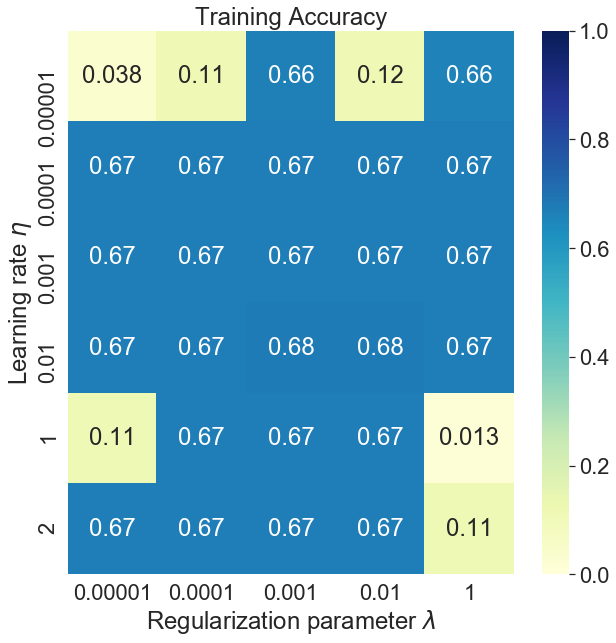

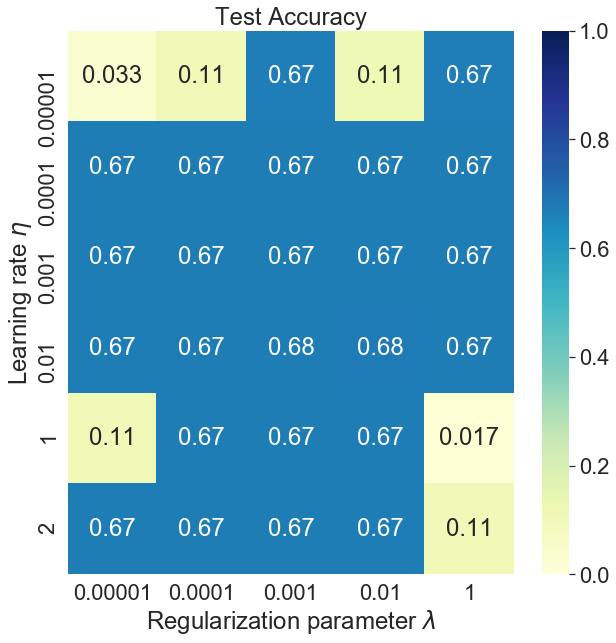

In [81]:
plot_etaVSlambda(train_accuracy, test_accuracy)

### Evaluation: number of neurons vs. number of filters

In [82]:
# Here we use eta = 0.01 and lambda = 0.01, since they denoted the best results

train_accuracy2 = np.zeros((len(n_neuron_values), len(n_filter_values)))
test_accuracy2 = np.zeros((len(n_neuron_values), len(n_filter_values)))
train_loss = np.zeros((len(n_neuron_values), len(n_filter_values)))
test_loss = np.zeros((len(n_neuron_values), len(n_filter_values)))

for i, n_neuron in enumerate(n_neuron_values):
    for j, n_filter in enumerate(n_filter_values):
        # Creating the model
        CNN_model = create_convolutional_NN(input_shape, n_neuron, n_categories, eta=0.01, lmbd=0.01, 
                                            n_filters = n_filter, filter_sizes = receptive_field)
        
        # Fitting the model with the training data
        CNN_model.fit(train, train_labels, epochs = epochs, batch_size = 100, verbose = 1, 
                      validation_data = (valid, valid_labels))
        
        # Saving accuracy scores 
        train_accuracy2[i][j] = CNN_model.evaluate(train, train_labels)[1]
        test_accuracy2[i][j] = CNN_model.evaluate(test, test_labels)[1]
        
        train_loss[i][j] = CNN_model.evaluate(train, train_labels)[0]
        test_loss[i][j] = CNN_model.evaluate(test, test_labels)[0]


Convolutional Neural Network model with the following parameters:
------------------------------------------------------------------
Learning rate eta =  0.01
regularization strength lambda =  0.01

Number of convolutional layers:  1
Number of filters in each convolutional layer:  5
Filter size in each convolutional layer:  3

Number of hidden layers:  1
Nunber of neurons in each hidden layer:  5
Train on 5408 samples, validate on 601 samples
Epoch 1/100
5408/5408 [==============================] - 11s 2ms/step - loss: 2.0391 - acc: 0.1840 - val_loss: 1.7222 - val_acc: 0.6589
Epoch 2/100
5408/5408 [==============================] - 1s 222us/step - loss: 1.5575 - acc: 0.6685 - val_loss: 1.4644 - val_acc: 0.6572
Epoch 3/100
5408/5408 [==============================] - 1s 223us/step - loss: 1.4016 - acc: 0.6686 - val_loss: 1.3878 - val_acc: 0.6572
Epoch 4/100
5408/5408 [==============================] - 1s 223us/step - loss: 1.3528 - acc: 0.6686 - val_loss: 1.3588 - val_acc: 0.6572
Epoch 

5408/5408 [==============================] - 1s 219us/step - loss: 1.1609 - acc: 0.6686 - val_loss: 1.2473 - val_acc: 0.6572 loss: 1.1641 - acc: 0.66
Epoch 57/100
5408/5408 [==============================] - 1s 216us/step - loss: 1.1606 - acc: 0.6686 - val_loss: 1.1807 - val_acc: 0.6572
Epoch 58/100
5408/5408 [==============================] - 1s 217us/step - loss: 1.1477 - acc: 0.6686 - val_loss: 1.1669 - val_acc: 0.6572
Epoch 59/100
5408/5408 [==============================] - 1s 212us/step - loss: 1.1415 - acc: 0.6686 - val_loss: 1.1483 - val_acc: 0.6572
Epoch 60/100
5408/5408 [==============================] - 1s 221us/step - loss: 1.1359 - acc: 0.6686 - val_loss: 1.1953 - val_acc: 0.6572
Epoch 61/100
5408/5408 [==============================] - 1s 219us/step - loss: 1.1309 - acc: 0.6686 - val_loss: 1.1381 - val_acc: 0.6572
Epoch 62/100
5408/5408 [==============================] - 1s 225us/step - loss: 1.1281 - acc: 0.6686 - val_loss: 1.1343 - val_acc: 0.6572
Epoch 63/100
5408/5408

5408/5408 [==============================] - 1s 227us/step - loss: 1.3465 - acc: 0.6686 - val_loss: 1.3588 - val_acc: 0.6572
Epoch 9/100
5408/5408 [==============================] - 1s 218us/step - loss: 1.3377 - acc: 0.6686 - val_loss: 1.3503 - val_acc: 0.6572
Epoch 10/100
5408/5408 [==============================] - 1s 221us/step - loss: 1.3301 - acc: 0.6686 - val_loss: 1.3427 - val_acc: 0.6572
Epoch 11/100
5408/5408 [==============================] - 1s 222us/step - loss: 1.3235 - acc: 0.6686 - val_loss: 1.3357 - val_acc: 0.6572
Epoch 12/100
5408/5408 [==============================] - 1s 219us/step - loss: 1.3175 - acc: 0.6686 - val_loss: 1.3294 - val_acc: 0.6572
Epoch 13/100
5408/5408 [==============================] - 1s 218us/step - loss: 1.3119 - acc: 0.6686 - val_loss: 1.3236 - val_acc: 0.6572
Epoch 14/100
5408/5408 [==============================] - 1s 223us/step - loss: 1.3069 - acc: 0.6686 - val_loss: 1.3188 - val_acc: 0.6572
Epoch 15/100
5408/5408 [========================

5408/5408 [==============================] - 1s 223us/step - loss: 1.1235 - acc: 0.6686 - val_loss: 1.1399 - val_acc: 0.6572
Epoch 68/100
5408/5408 [==============================] - 1s 232us/step - loss: 1.1204 - acc: 0.6686 - val_loss: 1.1498 - val_acc: 0.6572
Epoch 69/100
5408/5408 [==============================] - 1s 214us/step - loss: 1.1180 - acc: 0.6686 - val_loss: 1.2204 - val_acc: 0.6572
Epoch 70/100
5408/5408 [==============================] - 1s 220us/step - loss: 1.1231 - acc: 0.6686 - val_loss: 1.1422 - val_acc: 0.6572
Epoch 71/100
5408/5408 [==============================] - 1s 216us/step - loss: 1.1124 - acc: 0.6686 - val_loss: 1.1452 - val_acc: 0.6572
Epoch 72/100
5408/5408 [==============================] - 1s 228us/step - loss: 1.1088 - acc: 0.6686 - val_loss: 1.1269 - val_acc: 0.6572
Epoch 73/100
5408/5408 [==============================] - 1s 225us/step - loss: 1.1008 - acc: 0.6686 - val_loss: 1.1292 - val_acc: 0.6572
Epoch 74/100
5408/5408 [=======================

Epoch 21/100
5408/5408 [==============================] - 1s 250us/step - loss: 1.2648 - acc: 0.6686 - val_loss: 1.2748 - val_acc: 0.6572
Epoch 22/100
5408/5408 [==============================] - 1s 254us/step - loss: 1.2619 - acc: 0.6686 - val_loss: 1.2716 - val_acc: 0.6572
Epoch 23/100
5408/5408 [==============================] - 1s 250us/step - loss: 1.2593 - acc: 0.6686 - val_loss: 1.2688 - val_acc: 0.6572
Epoch 24/100
5408/5408 [==============================] - 1s 262us/step - loss: 1.2566 - acc: 0.6686 - val_loss: 1.2665 - val_acc: 0.6572
Epoch 25/100
5408/5408 [==============================] - 1s 236us/step - loss: 1.2539 - acc: 0.6686 - val_loss: 1.2640 - val_acc: 0.6572
Epoch 26/100
5408/5408 [==============================] - 1s 254us/step - loss: 1.2516 - acc: 0.6686 - val_loss: 1.2611 - val_acc: 0.6572
Epoch 27/100
5408/5408 [==============================] - 1s 276us/step - loss: 1.2491 - acc: 0.6686 - val_loss: 1.2587 - val_acc: 0.6572
Epoch 28/100
5408/5408 [==========

5408/5408 [==============================] - 1s 246us/step - loss: 1.1713 - acc: 0.6686 - val_loss: 1.1804 - val_acc: 0.6572
Epoch 81/100
5408/5408 [==============================] - 1s 251us/step - loss: 1.1705 - acc: 0.6686 - val_loss: 1.1790 - val_acc: 0.6572
Epoch 82/100
5408/5408 [==============================] - 1s 239us/step - loss: 1.1698 - acc: 0.6686 - val_loss: 1.1787 - val_acc: 0.6572
Epoch 83/100
5408/5408 [==============================] - 1s 242us/step - loss: 1.1691 - acc: 0.6686 - val_loss: 1.1781 - val_acc: 0.6572
Epoch 84/100
5408/5408 [==============================] - 1s 238us/step - loss: 1.1683 - acc: 0.6686 - val_loss: 1.1777 - val_acc: 0.6572
Epoch 85/100
5408/5408 [==============================] - 1s 237us/step - loss: 1.1677 - acc: 0.6686 - val_loss: 1.1769 - val_acc: 0.6572
Epoch 86/100
5408/5408 [==============================] - 1s 237us/step - loss: 1.1670 - acc: 0.6686 - val_loss: 1.1762 - val_acc: 0.6572
Epoch 87/100
5408/5408 [=======================

Epoch 34/100
5408/5408 [==============================] - 1s 229us/step - loss: 1.2376 - acc: 0.6686 - val_loss: 1.2474 - val_acc: 0.6572
Epoch 35/100
5408/5408 [==============================] - 1s 234us/step - loss: 1.2354 - acc: 0.6686 - val_loss: 1.2452 - val_acc: 0.6572
Epoch 36/100
5408/5408 [==============================] - 1s 229us/step - loss: 1.2333 - acc: 0.6686 - val_loss: 1.2432 - val_acc: 0.6572
Epoch 37/100
5408/5408 [==============================] - 1s 229us/step - loss: 1.2312 - acc: 0.6686 - val_loss: 1.2409 - val_acc: 0.6572
Epoch 38/100
5408/5408 [==============================] - 1s 226us/step - loss: 1.2292 - acc: 0.6686 - val_loss: 1.2388 - val_acc: 0.6572
Epoch 39/100
5408/5408 [==============================] - 1s 226us/step - loss: 1.2271 - acc: 0.6686 - val_loss: 1.2368 - val_acc: 0.6572
Epoch 40/100
5408/5408 [==============================] - 1s 226us/step - loss: 1.2252 - acc: 0.6686 - val_loss: 1.2349 - val_acc: 0.6572
Epoch 41/100
5408/5408 [==========

5408/5408 [==============================] - 1s 229us/step - loss: 1.0700 - acc: 0.6686 - val_loss: 1.1121 - val_acc: 0.6572
Epoch 94/100
5408/5408 [==============================] - 1s 225us/step - loss: 1.0633 - acc: 0.6686 - val_loss: 1.0745 - val_acc: 0.6572
Epoch 95/100
5408/5408 [==============================] - 1s 230us/step - loss: 1.0551 - acc: 0.6686 - val_loss: 1.0552 - val_acc: 0.6572
Epoch 96/100
5408/5408 [==============================] - 1s 234us/step - loss: 1.0475 - acc: 0.6686 - val_loss: 1.0588 - val_acc: 0.6572
Epoch 97/100
5408/5408 [==============================] - 1s 241us/step - loss: 1.0442 - acc: 0.6686 - val_loss: 1.1508 - val_acc: 0.6572
Epoch 98/100
5408/5408 [==============================] - 1s 236us/step - loss: 1.0704 - acc: 0.6686 - val_loss: 1.0640 - val_acc: 0.6572
Epoch 99/100
5408/5408 [==============================] - 1s 228us/step - loss: 1.0324 - acc: 0.6686 - val_loss: 1.0974 - val_acc: 0.6572
Epoch 100/100
4006/4006 [======================

5408/5408 [==============================] - 1s 264us/step - loss: 1.2258 - acc: 0.6686 - val_loss: 1.2357 - val_acc: 0.6572
Epoch 48/100
5408/5408 [==============================] - 1s 262us/step - loss: 1.2240 - acc: 0.6686 - val_loss: 1.2338 - val_acc: 0.6572
Epoch 49/100
5408/5408 [==============================] - 1s 264us/step - loss: 1.2222 - acc: 0.6686 - val_loss: 1.2320 - val_acc: 0.6572
Epoch 50/100
5408/5408 [==============================] - 1s 257us/step - loss: 1.2205 - acc: 0.6686 - val_loss: 1.2303 - val_acc: 0.6572
Epoch 51/100
5408/5408 [==============================] - 1s 251us/step - loss: 1.2188 - acc: 0.6686 - val_loss: 1.2286 - val_acc: 0.6572
Epoch 52/100
5408/5408 [==============================] - 1s 259us/step - loss: 1.2172 - acc: 0.6686 - val_loss: 1.2269 - val_acc: 0.6572
Epoch 53/100
5408/5408 [==============================] - 1s 255us/step - loss: 1.2156 - acc: 0.6686 - val_loss: 1.2251 - val_acc: 0.6572
Epoch 54/100
5408/5408 [=======================

5408/5408 [==============================] - 11s 2ms/step - loss: 1.7628 - acc: 0.6420 - val_loss: 1.5999 - val_acc: 0.6572
Epoch 2/100
5408/5408 [==============================] - 1s 211us/step - loss: 1.5291 - acc: 0.6686 - val_loss: 1.5227 - val_acc: 0.6572
Epoch 3/100
5408/5408 [==============================] - 1s 214us/step - loss: 1.4770 - acc: 0.6686 - val_loss: 1.4873 - val_acc: 0.6572
Epoch 4/100
5408/5408 [==============================] - 1s 214us/step - loss: 1.4502 - acc: 0.6686 - val_loss: 1.4652 - val_acc: 0.6572
Epoch 5/100
5408/5408 [==============================] - 1s 223us/step - loss: 1.4326 - acc: 0.6686 - val_loss: 1.4485 - val_acc: 0.6572
Epoch 6/100
5408/5408 [==============================] - 1s 214us/step - loss: 1.4191 - acc: 0.6686 - val_loss: 1.4351 - val_acc: 0.6572
Epoch 7/100
5408/5408 [==============================] - 1s 216us/step - loss: 1.4080 - acc: 0.6686 - val_loss: 1.4235 - val_acc: 0.6572
Epoch 8/100
5408/5408 [==============================]

5408/5408 [==============================] - 1s 223us/step - loss: 1.2204 - acc: 0.6686 - val_loss: 1.2294 - val_acc: 0.6572
Epoch 60/100
5408/5408 [==============================] - 1s 234us/step - loss: 1.2187 - acc: 0.6686 - val_loss: 1.2279 - val_acc: 0.6572
Epoch 61/100
5408/5408 [==============================] - 1s 246us/step - loss: 1.2170 - acc: 0.6686 - val_loss: 1.2260 - val_acc: 0.6572
Epoch 62/100
5408/5408 [==============================] - 1s 250us/step - loss: 1.2154 - acc: 0.6686 - val_loss: 1.2243 - val_acc: 0.6572
Epoch 63/100
5408/5408 [==============================] - 1s 268us/step - loss: 1.2137 - acc: 0.6686 - val_loss: 1.2229 - val_acc: 0.6572
Epoch 64/100
5408/5408 [==============================] - 1s 237us/step - loss: 1.2121 - acc: 0.6686 - val_loss: 1.2215 - val_acc: 0.6572
Epoch 65/100
5408/5408 [==============================] - 1s 240us/step - loss: 1.2106 - acc: 0.6686 - val_loss: 1.2199 - val_acc: 0.6572
Epoch 66/100
5408/5408 [=======================

Epoch 13/100
5408/5408 [==============================] - 1s 250us/step - loss: 1.3681 - acc: 0.6686 - val_loss: 1.3765 - val_acc: 0.6572
Epoch 14/100
5408/5408 [==============================] - 1s 248us/step - loss: 1.3617 - acc: 0.6686 - val_loss: 1.3699 - val_acc: 0.6572
Epoch 15/100
5408/5408 [==============================] - 1s 247us/step - loss: 1.3580 - acc: 0.6686 - val_loss: 1.3600 - val_acc: 0.6572
Epoch 16/100
5408/5408 [==============================] - 1s 248us/step - loss: 1.3515 - acc: 0.6686 - val_loss: 1.3781 - val_acc: 0.6572
Epoch 17/100
5408/5408 [==============================] - 1s 241us/step - loss: 1.3631 - acc: 0.6686 - val_loss: 1.3686 - val_acc: 0.6572
Epoch 18/100
5408/5408 [==============================] - 1s 253us/step - loss: 1.3544 - acc: 0.6686 - val_loss: 1.3627 - val_acc: 0.6572
Epoch 19/100
5408/5408 [==============================] - 1s 260us/step - loss: 1.3480 - acc: 0.6686 - val_loss: 1.3577 - val_acc: 0.6572
Epoch 20/100
5408/5408 [==========

5408/5408 [==============================] - 2s 310us/step - loss: 1.0380 - acc: 0.6790 - val_loss: 1.0433 - val_acc: 0.6739
Epoch 73/100
5408/5408 [==============================] - 1s 249us/step - loss: 1.0375 - acc: 0.6820 - val_loss: 1.0411 - val_acc: 0.6572
Epoch 74/100
5408/5408 [==============================] - 1s 268us/step - loss: 1.0313 - acc: 0.6757 - val_loss: 1.1100 - val_acc: 0.6656
Epoch 75/100
5408/5408 [==============================] - 1s 270us/step - loss: 1.0465 - acc: 0.6696 - val_loss: 1.0931 - val_acc: 0.6589
Epoch 76/100
5408/5408 [==============================] - 1s 268us/step - loss: 1.0343 - acc: 0.6788 - val_loss: 1.0242 - val_acc: 0.6722
Epoch 77/100
5408/5408 [==============================] - 1s 251us/step - loss: 1.0296 - acc: 0.6823 - val_loss: 1.0848 - val_acc: 0.6589
Epoch 78/100
5408/5408 [==============================] - 1s 250us/step - loss: 1.0241 - acc: 0.6821 - val_loss: 1.0847 - val_acc: 0.6423
Epoch 79/100
5408/5408 [=======================

Epoch 26/100
5408/5408 [==============================] - 1s 269us/step - loss: 1.3180 - acc: 0.6686 - val_loss: 1.3257 - val_acc: 0.6572
Epoch 27/100
5408/5408 [==============================] - 2s 296us/step - loss: 1.3140 - acc: 0.6686 - val_loss: 1.3216 - val_acc: 0.6572
Epoch 28/100
5408/5408 [==============================] - 1s 247us/step - loss: 1.3102 - acc: 0.6686 - val_loss: 1.3180 - val_acc: 0.6572
Epoch 29/100
5408/5408 [==============================] - 1s 220us/step - loss: 1.3064 - acc: 0.6686 - val_loss: 1.3145 - val_acc: 0.6572
Epoch 30/100
5408/5408 [==============================] - 1s 223us/step - loss: 1.3026 - acc: 0.6686 - val_loss: 1.3098 - val_acc: 0.6572
Epoch 31/100
5408/5408 [==============================] - 1s 228us/step - loss: 1.2991 - acc: 0.6686 - val_loss: 1.3064 - val_acc: 0.6572
Epoch 32/100
5408/5408 [==============================] - 1s 217us/step - loss: 1.2955 - acc: 0.6686 - val_loss: 1.3033 - val_acc: 0.6572
Epoch 33/100
5408/5408 [==========

Epoch 85/100
5408/5408 [==============================] - 1s 213us/step - loss: 1.0317 - acc: 0.6686 - val_loss: 1.0849 - val_acc: 0.6572
Epoch 86/100
5408/5408 [==============================] - 1s 210us/step - loss: 1.0312 - acc: 0.6686 - val_loss: 1.0662 - val_acc: 0.6572
Epoch 87/100
5408/5408 [==============================] - 1s 207us/step - loss: 1.0280 - acc: 0.6686 - val_loss: 1.0562 - val_acc: 0.6572
Epoch 88/100
5408/5408 [==============================] - 1s 238us/step - loss: 1.0223 - acc: 0.6686 - val_loss: 1.0393 - val_acc: 0.6572
Epoch 89/100
5408/5408 [==============================] - 1s 234us/step - loss: 1.0181 - acc: 0.6686 - val_loss: 1.1566 - val_acc: 0.6572
Epoch 90/100
5408/5408 [==============================] - 1s 223us/step - loss: 1.0195 - acc: 0.6688 - val_loss: 1.0837 - val_acc: 0.6572
Epoch 91/100
5408/5408 [==============================] - 1s 225us/step - loss: 1.0171 - acc: 0.6690 - val_loss: 1.0474 - val_acc: 0.6572
Epoch 92/100
5408/5408 [==========

5408/5408 [==============================] - ETA: 0s - loss: 1.2151 - acc: 0.6687- ETA: 0s - loss: 1.2173 - acc: 0.669 - ETA: 0s - loss: 1.2218 -  - 1s 215us/step - loss: 1.2156 - acc: 0.6686 - val_loss: 1.2313 - val_acc: 0.6572
Epoch 40/100
5408/5408 [==============================] - 1s 220us/step - loss: 1.2139 - acc: 0.6686 - val_loss: 1.2593 - val_acc: 0.6572
Epoch 41/100
5408/5408 [==============================] - 1s 214us/step - loss: 1.2091 - acc: 0.6686 - val_loss: 1.2242 - val_acc: 0.6572
Epoch 42/100
5408/5408 [==============================] - 1s 214us/step - loss: 1.1923 - acc: 0.6686 - val_loss: 1.2255 - val_acc: 0.6572
Epoch 43/100
5408/5408 [==============================] - 1s 216us/step - loss: 1.1877 - acc: 0.6686 - val_loss: 1.2060 - val_acc: 0.6572
Epoch 44/100
5408/5408 [==============================] - 1s 216us/step - loss: 1.1812 - acc: 0.6686 - val_loss: 1.2036 - val_acc: 0.6572
Epoch 45/100
5408/5408 [==============================] - 1s 217us/step - loss: 1

5408/5408 [==============================] - 1s 214us/step - loss: 0.9850 - acc: 0.6884 - val_loss: 1.0068 - val_acc: 0.6705
Epoch 98/100
5408/5408 [==============================] - 1s 213us/step - loss: 0.9794 - acc: 0.6871 - val_loss: 0.9846 - val_acc: 0.6872
Epoch 99/100
5408/5408 [==============================] - 1s 217us/step - loss: 0.9709 - acc: 0.6916 - val_loss: 1.0085 - val_acc: 0.6722
Epoch 100/100
4006/4006 [==============================] - 1s 235us/step
Convolutional Neural Network model with the following parameters:
------------------------------------------------------------------
Learning rate eta =  0.01
regularization strength lambda =  0.01

Number of convolutional layers:  1
Number of filters in each convolutional layer:  25
Filter size in each convolutional layer:  3

Number of hidden layers:  1
Nunber of neurons in each hidden layer:  10
Train on 5408 samples, validate on 601 samples
Epoch 1/100
5408/5408 [==============================] - 13s 2ms/step - loss:

5408/5408 [==============================] - 1s 238us/step - loss: 1.1003 - acc: 0.6685 - val_loss: 1.1622 - val_acc: 0.6572
Epoch 52/100
5408/5408 [==============================] - 1s 235us/step - loss: 1.0957 - acc: 0.6686 - val_loss: 1.1371 - val_acc: 0.6572
Epoch 53/100
5408/5408 [==============================] - 1s 234us/step - loss: 1.0892 - acc: 0.6688 - val_loss: 1.2582 - val_acc: 0.6572
Epoch 54/100
5408/5408 [==============================] - 1s 232us/step - loss: 1.0977 - acc: 0.6686 - val_loss: 1.1284 - val_acc: 0.6572
Epoch 55/100
5408/5408 [==============================] - 1s 238us/step - loss: 1.0828 - acc: 0.6686 - val_loss: 1.2071 - val_acc: 0.6572
Epoch 56/100
5408/5408 [==============================] - 1s 241us/step - loss: 1.1345 - acc: 0.6686 - val_loss: 1.4688 - val_acc: 0.6572
Epoch 57/100
5408/5408 [==============================] - 1s 238us/step - loss: 1.1259 - acc: 0.6686 - val_loss: 1.1666 - val_acc: 0.6572
Epoch 58/100
5408/5408 [=======================

5408/5408 [==============================] - 1s 207us/step - loss: 1.5421 - acc: 0.6686 - val_loss: 1.5726 - val_acc: 0.6572
Epoch 6/100
5408/5408 [==============================] - 1s 207us/step - loss: 1.5483 - acc: 0.6685 - val_loss: 1.5399 - val_acc: 0.6572
Epoch 7/100
5408/5408 [==============================] - 1s 207us/step - loss: 1.5272 - acc: 0.6686 - val_loss: 1.5261 - val_acc: 0.6572
Epoch 8/100
5408/5408 [==============================] - 1s 266us/step - loss: 1.5152 - acc: 0.6686 - val_loss: 1.5150 - val_acc: 0.6572
Epoch 9/100
5408/5408 [==============================] - 1s 233us/step - loss: 1.5048 - acc: 0.6686 - val_loss: 1.5065 - val_acc: 0.6572
Epoch 10/100
5408/5408 [==============================] - 1s 244us/step - loss: 1.4985 - acc: 0.6686 - val_loss: 1.4972 - val_acc: 0.6572
Epoch 11/100
5408/5408 [==============================] - 1s 230us/step - loss: 1.4886 - acc: 0.6686 - val_loss: 1.4869 - val_acc: 0.6572
Epoch 12/100
5408/5408 [===========================

5408/5408 [==============================] - 1s 256us/step - loss: 1.2433 - acc: 0.6686 - val_loss: 1.2516 - val_acc: 0.6572
Epoch 65/100
5408/5408 [==============================] - 1s 253us/step - loss: 1.2408 - acc: 0.6686 - val_loss: 1.2494 - val_acc: 0.6572
Epoch 66/100
5408/5408 [==============================] - 1s 257us/step - loss: 1.2387 - acc: 0.6686 - val_loss: 1.2463 - val_acc: 0.6572
Epoch 67/100
5408/5408 [==============================] - 1s 231us/step - loss: 1.2363 - acc: 0.6686 - val_loss: 1.2446 - val_acc: 0.6572
Epoch 68/100
5408/5408 [==============================] - 2s 292us/step - loss: 1.2341 - acc: 0.6686 - val_loss: 1.2423 - val_acc: 0.6572
Epoch 69/100
5408/5408 [==============================] - 1s 254us/step - loss: 1.2319 - acc: 0.6686 - val_loss: 1.2393 - val_acc: 0.6572
Epoch 70/100
5408/5408 [==============================] - 1s 210us/step - loss: 1.2300 - acc: 0.6686 - val_loss: 1.2378 - val_acc: 0.6572
Epoch 71/100
5408/5408 [=======================

5408/5408 [==============================] - 1s 256us/step - loss: 1.4193 - acc: 0.6686 - val_loss: 1.4575 - val_acc: 0.6572
Epoch 19/100
5408/5408 [==============================] - 1s 257us/step - loss: 1.4070 - acc: 0.6686 - val_loss: 1.4167 - val_acc: 0.6572
Epoch 20/100
5408/5408 [==============================] - 1s 244us/step - loss: 1.3902 - acc: 0.6686 - val_loss: 1.4475 - val_acc: 0.6572 0s - loss: 1.4011 - acc
Epoch 21/100
5408/5408 [==============================] - 1s 253us/step - loss: 1.3832 - acc: 0.6686 - val_loss: 1.4589 - val_acc: 0.6572
Epoch 22/100
5408/5408 [==============================] - 1s 242us/step - loss: 1.3739 - acc: 0.6686 - val_loss: 1.4088 - val_acc: 0.6572
Epoch 23/100
5408/5408 [==============================] - 1s 253us/step - loss: 1.3687 - acc: 0.6686 - val_loss: 1.3747 - val_acc: 0.6572
Epoch 24/100
5408/5408 [==============================] - 1s 220us/step - loss: 1.3534 - acc: 0.6686 - val_loss: 1.3620 - val_acc: 0.6572
Epoch 25/100
5408/5408 

5408/5408 [==============================] - 1s 230us/step - loss: 1.0417 - acc: 0.6825 - val_loss: 1.0671 - val_acc: 0.6622
Epoch 78/100
5408/5408 [==============================] - 1s 231us/step - loss: 1.0362 - acc: 0.6799 - val_loss: 1.0520 - val_acc: 0.6705
Epoch 79/100
5408/5408 [==============================] - 1s 229us/step - loss: 1.0401 - acc: 0.6821 - val_loss: 1.3154 - val_acc: 0.6572
Epoch 80/100
5408/5408 [==============================] - 1s 229us/step - loss: 1.0332 - acc: 0.6842 - val_loss: 1.1101 - val_acc: 0.6689
Epoch 81/100
5408/5408 [==============================] - 1s 230us/step - loss: 1.0308 - acc: 0.6814 - val_loss: 1.0696 - val_acc: 0.6622
Epoch 82/100
5408/5408 [==============================] - 1s 237us/step - loss: 1.0200 - acc: 0.6899 - val_loss: 1.5536 - val_acc: 0.6572
Epoch 83/100
5408/5408 [==============================] - 1s 233us/step - loss: 1.0569 - acc: 0.6781 - val_loss: 1.2227 - val_acc: 0.6622
Epoch 84/100
5408/5408 [=======================

5408/5408 [==============================] - 1s 225us/step - loss: 1.3808 - acc: 0.6686 - val_loss: 1.3969 - val_acc: 0.6572
Epoch 32/100
5408/5408 [==============================] - 1s 228us/step - loss: 1.3749 - acc: 0.6686 - val_loss: 1.3766 - val_acc: 0.6572
Epoch 33/100
5408/5408 [==============================] - 1s 228us/step - loss: 1.3648 - acc: 0.6686 - val_loss: 1.3553 - val_acc: 0.6572
Epoch 34/100
5408/5408 [==============================] - 1s 228us/step - loss: 1.3508 - acc: 0.6686 - val_loss: 1.3585 - val_acc: 0.6572
Epoch 35/100
5408/5408 [==============================] - 1s 229us/step - loss: 1.3393 - acc: 0.6686 - val_loss: 1.3720 - val_acc: 0.6572
Epoch 36/100
5408/5408 [==============================] - 1s 237us/step - loss: 1.3308 - acc: 0.6686 - val_loss: 1.3535 - val_acc: 0.6572
Epoch 37/100
5408/5408 [==============================] - 1s 264us/step - loss: 1.3132 - acc: 0.6686 - val_loss: 1.3526 - val_acc: 0.6572
Epoch 38/100
5408/5408 [=======================

5408/5408 [==============================] - 1s 225us/step - loss: 0.9876 - acc: 0.6929 - val_loss: 1.0498 - val_acc: 0.6656
Epoch 91/100
5408/5408 [==============================] - 1s 225us/step - loss: 0.9864 - acc: 0.6890 - val_loss: 1.2190 - val_acc: 0.6090
Epoch 92/100
5408/5408 [==============================] - 1s 232us/step - loss: 1.0029 - acc: 0.6842 - val_loss: 1.4129 - val_acc: 0.4775
Epoch 93/100
5408/5408 [==============================] - 1s 234us/step - loss: 1.0171 - acc: 0.6799 - val_loss: 1.0732 - val_acc: 0.6572
Epoch 94/100
5408/5408 [==============================] - 1s 225us/step - loss: 0.9860 - acc: 0.6888 - val_loss: 1.0341 - val_acc: 0.6755
Epoch 95/100
5408/5408 [==============================] - 1s 227us/step - loss: 0.9824 - acc: 0.6912 - val_loss: 1.1440 - val_acc: 0.6689
Epoch 96/100
5408/5408 [==============================] - 1s 225us/step - loss: 0.9799 - acc: 0.6921 - val_loss: 1.0849 - val_acc: 0.6539
Epoch 97/100
5408/5408 [=======================

5408/5408 [==============================] - 2s 283us/step - loss: 1.1757 - acc: 0.6746 - val_loss: 1.1813 - val_acc: 0.6556
Epoch 44/100
5408/5408 [==============================] - 1s 268us/step - loss: 1.1597 - acc: 0.6736 - val_loss: 1.1991 - val_acc: 0.6539
Epoch 45/100
5408/5408 [==============================] - 2s 285us/step - loss: 1.1601 - acc: 0.6749 - val_loss: 1.1846 - val_acc: 0.6572
Epoch 46/100
5408/5408 [==============================] - 1s 238us/step - loss: 1.1512 - acc: 0.6777 - val_loss: 1.1665 - val_acc: 0.6739
Epoch 47/100
5408/5408 [==============================] - 1s 243us/step - loss: 1.1479 - acc: 0.6775 - val_loss: 1.2090 - val_acc: 0.6589
Epoch 48/100
5408/5408 [==============================] - 1s 233us/step - loss: 1.1468 - acc: 0.6744 - val_loss: 1.2534 - val_acc: 0.6306
Epoch 49/100
5408/5408 [==============================] - 1s 247us/step - loss: 1.1353 - acc: 0.6781 - val_loss: 1.1832 - val_acc: 0.6556
Epoch 50/100
5408/5408 [=======================

4006/4006 [==============================] - 1s 246us/step
Convolutional Neural Network model with the following parameters:
------------------------------------------------------------------
Learning rate eta =  0.01
regularization strength lambda =  0.01

Number of convolutional layers:  1
Number of filters in each convolutional layer:  25
Filter size in each convolutional layer:  3

Number of hidden layers:  1
Nunber of neurons in each hidden layer:  20
Train on 5408 samples, validate on 601 samples
Epoch 1/100
5408/5408 [==============================] - 13s 2ms/step - loss: 1.8227 - acc: 0.6522 - val_loss: 1.7557 - val_acc: 0.6572
Epoch 2/100
5408/5408 [==============================] - 1s 267us/step - loss: 1.7061 - acc: 0.6686 - val_loss: 1.7117 - val_acc: 0.6572
Epoch 3/100
5408/5408 [==============================] - 1s 269us/step - loss: 1.6761 - acc: 0.6686 - val_loss: 1.6834 - val_acc: 0.6572
Epoch 4/100
5408/5408 [==============================] - 1s 269us/step - loss: 1.6

Epoch 57/100
5408/5408 [==============================] - ETA: 0s - loss: 1.2960 - acc: 0.667 - 1s 241us/step - loss: 1.2942 - acc: 0.6686 - val_loss: 1.3006 - val_acc: 0.6572
Epoch 58/100
5408/5408 [==============================] - 1s 241us/step - loss: 1.2906 - acc: 0.6686 - val_loss: 1.2972 - val_acc: 0.6572
Epoch 59/100
5408/5408 [==============================] - 1s 241us/step - loss: 1.2872 - acc: 0.6686 - val_loss: 1.2948 - val_acc: 0.6572
Epoch 60/100
5408/5408 [==============================] - 1s 247us/step - loss: 1.2839 - acc: 0.6686 - val_loss: 1.2919 - val_acc: 0.6572
Epoch 61/100
5408/5408 [==============================] - 2s 282us/step - loss: 1.2806 - acc: 0.6686 - val_loss: 1.2887 - val_acc: 0.6572
Epoch 62/100
5408/5408 [==============================] - 1s 254us/step - loss: 1.2775 - acc: 0.6686 - val_loss: 1.2850 - val_acc: 0.6572
Epoch 63/100
5408/5408 [==============================] - 1s 247us/step - loss: 1.2744 - acc: 0.6686 - val_loss: 1.2819 - val_acc: 0.6

5408/5408 [==============================] - 1s 241us/step - loss: 1.5011 - acc: 0.6686 - val_loss: 1.5644 - val_acc: 0.6572
Epoch 12/100
5408/5408 [==============================] - ETA: 0s - loss: 1.4815 - acc: 0.668 - 1s 228us/step - loss: 1.4809 - acc: 0.6686 - val_loss: 1.5173 - val_acc: 0.6572
Epoch 13/100
5408/5408 [==============================] - 1s 229us/step - loss: 1.4691 - acc: 0.6686 - val_loss: 1.4921 - val_acc: 0.6572
Epoch 14/100
5408/5408 [==============================] - 1s 231us/step - loss: 1.4504 - acc: 0.6686 - val_loss: 1.4727 - val_acc: 0.6572
Epoch 15/100
5408/5408 [==============================] - 1s 235us/step - loss: 1.4396 - acc: 0.6686 - val_loss: 1.4582 - val_acc: 0.6572
Epoch 16/100
5408/5408 [==============================] - 1s 223us/step - loss: 1.4265 - acc: 0.6686 - val_loss: 1.5544 - val_acc: 0.6572
Epoch 17/100
5408/5408 [==============================] - 1s 231us/step - loss: 1.4153 - acc: 0.6686 - val_loss: 1.4603 - val_acc: 0.6572
Epoch 18/

Epoch 70/100
5408/5408 [==============================] - 1s 223us/step - loss: 1.0564 - acc: 0.6834 - val_loss: 1.2036 - val_acc: 0.6572
Epoch 71/100
5408/5408 [==============================] - 1s 217us/step - loss: 1.0631 - acc: 0.6784 - val_loss: 1.1710 - val_acc: 0.6572
Epoch 72/100
5408/5408 [==============================] - 1s 216us/step - loss: 1.0588 - acc: 0.6801 - val_loss: 1.0664 - val_acc: 0.6705
Epoch 73/100
5408/5408 [==============================] - 1s 217us/step - loss: 1.0508 - acc: 0.6803 - val_loss: 1.1490 - val_acc: 0.6572
Epoch 74/100
5408/5408 [==============================] - 1s 217us/step - loss: 1.0511 - acc: 0.6814 - val_loss: 1.0795 - val_acc: 0.6606
Epoch 75/100
5408/5408 [==============================] - 1s 226us/step - loss: 1.0503 - acc: 0.6808 - val_loss: 1.0767 - val_acc: 0.6755
Epoch 76/100
5408/5408 [==============================] - 1s 234us/step - loss: 1.0426 - acc: 0.6818 - val_loss: 1.0609 - val_acc: 0.6755
Epoch 77/100
5408/5408 [==========

5408/5408 [==============================] - 1s 228us/step - loss: 1.3529 - acc: 0.6686 - val_loss: 1.4230 - val_acc: 0.6572
Epoch 25/100
5408/5408 [==============================] - 1s 230us/step - loss: 1.3392 - acc: 0.6686 - val_loss: 1.3576 - val_acc: 0.6572
Epoch 26/100
5408/5408 [==============================] - 1s 225us/step - loss: 1.3243 - acc: 0.6686 - val_loss: 1.4136 - val_acc: 0.6572
Epoch 27/100
5408/5408 [==============================] - 1s 225us/step - loss: 1.3273 - acc: 0.6686 - val_loss: 1.4457 - val_acc: 0.6572
Epoch 28/100
5408/5408 [==============================] - 1s 227us/step - loss: 1.3109 - acc: 0.6686 - val_loss: 1.3663 - val_acc: 0.6572
Epoch 29/100
5408/5408 [==============================] - 1s 228us/step - loss: 1.2993 - acc: 0.6686 - val_loss: 1.3403 - val_acc: 0.6572
Epoch 30/100
5408/5408 [==============================] - 1s 232us/step - loss: 1.2852 - acc: 0.6686 - val_loss: 1.4271 - val_acc: 0.6572
Epoch 31/100
5408/5408 [=======================

5408/5408 [==============================] - 2s 320us/step - loss: 1.0303 - acc: 0.6860 - val_loss: 1.1039 - val_acc: 0.6606
Epoch 84/100
5408/5408 [==============================] - 1s 233us/step - loss: 1.0281 - acc: 0.6847 - val_loss: 1.0156 - val_acc: 0.6805
Epoch 85/100
5408/5408 [==============================] - 1s 228us/step - loss: 1.0158 - acc: 0.6858 - val_loss: 1.2431 - val_acc: 0.5607
Epoch 86/100
5408/5408 [==============================] - 1s 225us/step - loss: 1.0261 - acc: 0.6818 - val_loss: 1.1756 - val_acc: 0.6556
Epoch 87/100
5408/5408 [==============================] - 1s 222us/step - loss: 1.0251 - acc: 0.6842 - val_loss: 1.0562 - val_acc: 0.6755
Epoch 88/100
5408/5408 [==============================] - 1s 244us/step - loss: 1.0120 - acc: 0.6836 - val_loss: 1.0241 - val_acc: 0.6739
Epoch 89/100
5408/5408 [==============================] - 1s 269us/step - loss: 1.0098 - acc: 0.6853 - val_loss: 1.1355 - val_acc: 0.6539
Epoch 90/100
5408/5408 [=======================

5408/5408 [==============================] - 1s 265us/step - loss: 1.2318 - acc: 0.6823 - val_loss: 1.2418 - val_acc: 0.6772
Epoch 38/100
5408/5408 [==============================] - 2s 286us/step - loss: 1.2000 - acc: 0.6842 - val_loss: 1.2706 - val_acc: 0.6722
Epoch 39/100
5408/5408 [==============================] - 1s 273us/step - loss: 1.1966 - acc: 0.6866 - val_loss: 1.2326 - val_acc: 0.6755
Epoch 40/100
5408/5408 [==============================] - 1s 263us/step - loss: 1.1834 - acc: 0.6890 - val_loss: 1.2680 - val_acc: 0.6622
Epoch 41/100
5408/5408 [==============================] - 1s 273us/step - loss: 1.1895 - acc: 0.6853 - val_loss: 1.2082 - val_acc: 0.6722
Epoch 42/100
5408/5408 [==============================] - 2s 356us/step - loss: 1.1709 - acc: 0.6899 - val_loss: 1.1877 - val_acc: 0.6755
Epoch 43/100
5408/5408 [==============================] - 2s 353us/step - loss: 1.1603 - acc: 0.6888 - val_loss: 1.1893 - val_acc: 0.6789
Epoch 44/100
5408/5408 [=======================

5408/5408 [==============================] - 2s 302us/step - loss: 0.9584 - acc: 0.6999 - val_loss: 0.9884 - val_acc: 0.6772
Epoch 97/100
5408/5408 [==============================] - 1s 274us/step - loss: 0.9570 - acc: 0.6999 - val_loss: 1.0164 - val_acc: 0.6705
Epoch 98/100
5408/5408 [==============================] - 2s 285us/step - loss: 0.9517 - acc: 0.7004 - val_loss: 0.9980 - val_acc: 0.6656
Epoch 99/100
5408/5408 [==============================] - 2s 298us/step - loss: 0.9504 - acc: 0.7014 - val_loss: 0.9780 - val_acc: 0.6822
Epoch 100/100
4006/4006 [==============================] - 1s 305us/step
Convolutional Neural Network model with the following parameters:
------------------------------------------------------------------
Learning rate eta =  0.01
regularization strength lambda =  0.01

Number of convolutional layers:  1
Number of filters in each convolutional layer:  20
Filter size in each convolutional layer:  3

Number of hidden layers:  1
Nunber of neurons in each hidd

5408/5408 [==============================] - 2s 306us/step - loss: 1.1666 - acc: 0.6855 - val_loss: 1.1821 - val_acc: 0.6672
Epoch 51/100
5408/5408 [==============================] - 1s 263us/step - loss: 1.1592 - acc: 0.6814 - val_loss: 1.2120 - val_acc: 0.6572
Epoch 52/100
5408/5408 [==============================] - 1s 254us/step - loss: 1.1551 - acc: 0.6792 - val_loss: 1.2041 - val_acc: 0.6722
Epoch 53/100
5408/5408 [==============================] - 2s 281us/step - loss: 1.1489 - acc: 0.6790 - val_loss: 1.1923 - val_acc: 0.6639
Epoch 54/100
5408/5408 [==============================] - 1s 271us/step - loss: 1.1419 - acc: 0.6825 - val_loss: 1.2020 - val_acc: 0.6589
Epoch 55/100
5408/5408 [==============================] - 1s 271us/step - loss: 1.1344 - acc: 0.6831 - val_loss: 1.1971 - val_acc: 0.6639
Epoch 56/100
5408/5408 [==============================] - 1s 257us/step - loss: 1.1332 - acc: 0.6799 - val_loss: 1.2784 - val_acc: 0.6572
Epoch 57/100
5408/5408 [=======================

5408/5408 [==============================] - 1s 274us/step - loss: 1.7580 - acc: 0.6686 - val_loss: 1.8038 - val_acc: 0.6572
Epoch 5/100
5408/5408 [==============================] - 2s 320us/step - loss: 1.7595 - acc: 0.6686 - val_loss: 1.7554 - val_acc: 0.6572
Epoch 6/100
5408/5408 [==============================] - 2s 311us/step - loss: 1.7362 - acc: 0.6686 - val_loss: 1.7581 - val_acc: 0.6572
Epoch 7/100
5408/5408 [==============================] - 2s 309us/step - loss: 1.7205 - acc: 0.6686 - val_loss: 1.7412 - val_acc: 0.6572
Epoch 8/100
5408/5408 [==============================] - 2s 310us/step - loss: 1.7232 - acc: 0.6686 - val_loss: 1.7285 - val_acc: 0.6572
Epoch 9/100
5408/5408 [==============================] - 2s 315us/step - loss: 1.6992 - acc: 0.6686 - val_loss: 1.6884 - val_acc: 0.6572
Epoch 10/100
5408/5408 [==============================] - 2s 318us/step - loss: 1.6697 - acc: 0.6686 - val_loss: 1.6599 - val_acc: 0.6572
Epoch 11/100
5408/5408 [============================

5408/5408 [==============================] - 2s 347us/step - loss: 1.1074 - acc: 0.6820 - val_loss: 1.6124 - val_acc: 0.6572
Epoch 64/100
5408/5408 [==============================] - 2s 392us/step - loss: 1.1861 - acc: 0.6753 - val_loss: 1.1221 - val_acc: 0.6705
Epoch 65/100
5408/5408 [==============================] - 2s 323us/step - loss: 1.1058 - acc: 0.6840 - val_loss: 1.1018 - val_acc: 0.6822
Epoch 66/100
5408/5408 [==============================] - 2s 343us/step - loss: 1.0975 - acc: 0.6814 - val_loss: 1.1072 - val_acc: 0.6722
Epoch 67/100
5408/5408 [==============================] - 2s 349us/step - loss: 1.0880 - acc: 0.6897 - val_loss: 1.1326 - val_acc: 0.6622
Epoch 68/100
5408/5408 [==============================] - 2s 307us/step - loss: 1.0901 - acc: 0.6881 - val_loss: 1.1130 - val_acc: 0.6789
Epoch 69/100
5408/5408 [==============================] - 2s 345us/step - loss: 1.0787 - acc: 0.6892 - val_loss: 1.1593 - val_acc: 0.6606
Epoch 70/100
5408/5408 [=======================

5408/5408 [==============================] - 1s 230us/step - loss: 1.4414 - acc: 0.6686 - val_loss: 1.4450 - val_acc: 0.6572
Epoch 18/100
5408/5408 [==============================] - 1s 228us/step - loss: 1.4281 - acc: 0.6686 - val_loss: 1.4846 - val_acc: 0.6572
Epoch 19/100
5408/5408 [==============================] - 1s 255us/step - loss: 1.4201 - acc: 0.6686 - val_loss: 1.4381 - val_acc: 0.6572
Epoch 20/100
5408/5408 [==============================] - 2s 283us/step - loss: 1.4074 - acc: 0.6686 - val_loss: 1.4350 - val_acc: 0.6572
Epoch 21/100
5408/5408 [==============================] - 2s 300us/step - loss: 1.3915 - acc: 0.6686 - val_loss: 1.4974 - val_acc: 0.6572
Epoch 22/100
5408/5408 [==============================] - 2s 278us/step - loss: 1.3828 - acc: 0.6686 - val_loss: 1.4155 - val_acc: 0.6572
Epoch 23/100
5408/5408 [==============================] - 1s 256us/step - loss: 1.3778 - acc: 0.6686 - val_loss: 1.4271 - val_acc: 0.6572
Epoch 24/100
5408/5408 [=======================

5408/5408 [==============================] - 1s 224us/step - loss: 1.0660 - acc: 0.6792 - val_loss: 1.6653 - val_acc: 0.6572
Epoch 77/100
5408/5408 [==============================] - 1s 216us/step - loss: 1.0667 - acc: 0.6821 - val_loss: 1.0608 - val_acc: 0.6839
Epoch 78/100
5408/5408 [==============================] - 1s 207us/step - loss: 1.0454 - acc: 0.6820 - val_loss: 1.2843 - val_acc: 0.6572
Epoch 79/100
5408/5408 [==============================] - 1s 210us/step - loss: 1.0589 - acc: 0.6821 - val_loss: 1.0931 - val_acc: 0.6689
Epoch 80/100
5408/5408 [==============================] - 1s 228us/step - loss: 1.0508 - acc: 0.6825 - val_loss: 1.1154 - val_acc: 0.6789
Epoch 81/100
5408/5408 [==============================] - 1s 211us/step - loss: 1.0422 - acc: 0.6831 - val_loss: 1.1536 - val_acc: 0.6705
Epoch 82/100
5408/5408 [==============================] - 1s 210us/step - loss: 1.0390 - acc: 0.6836 - val_loss: 1.0742 - val_acc: 0.6772
Epoch 83/100
5408/5408 [=======================

5408/5408 [==============================] - 2s 281us/step - loss: 1.3628 - acc: 0.6686 - val_loss: 1.4151 - val_acc: 0.6572
Epoch 31/100
5408/5408 [==============================] - 1s 251us/step - loss: 1.3543 - acc: 0.6686 - val_loss: 1.4377 - val_acc: 0.6572
Epoch 32/100
5408/5408 [==============================] - 2s 293us/step - loss: 1.3453 - acc: 0.6688 - val_loss: 1.3691 - val_acc: 0.6572
Epoch 33/100
5408/5408 [==============================] - 1s 257us/step - loss: 1.3295 - acc: 0.6694 - val_loss: 1.3424 - val_acc: 0.6589
Epoch 34/100
5408/5408 [==============================] - 1s 254us/step - loss: 1.3140 - acc: 0.6696 - val_loss: 1.3727 - val_acc: 0.6572
Epoch 35/100
5408/5408 [==============================] - 1s 260us/step - loss: 1.3036 - acc: 0.6710 - val_loss: 1.3464 - val_acc: 0.65720s - loss: 1.3076 - a
Epoch 36/100
5408/5408 [==============================] - 1s 263us/step - loss: 1.2930 - acc: 0.6727 - val_loss: 1.2993 - val_acc: 0.6622
Epoch 37/100
5408/5408 [==

5408/5408 [==============================] - 1s 247us/step - loss: 1.0034 - acc: 0.6914 - val_loss: 1.4082 - val_acc: 0.5025
Epoch 90/100
5408/5408 [==============================] - 1s 247us/step - loss: 1.0105 - acc: 0.6869 - val_loss: 1.0830 - val_acc: 0.6805
Epoch 91/100
5408/5408 [==============================] - 1s 237us/step - loss: 1.0082 - acc: 0.6932 - val_loss: 1.0525 - val_acc: 0.6739
Epoch 92/100
5408/5408 [==============================] - 1s 265us/step - loss: 1.0035 - acc: 0.6943 - val_loss: 1.0523 - val_acc: 0.6722
Epoch 93/100
5408/5408 [==============================] - 1s 229us/step - loss: 1.0021 - acc: 0.6893 - val_loss: 1.0876 - val_acc: 0.6656
Epoch 94/100
5408/5408 [==============================] - 1s 275us/step - loss: 1.0042 - acc: 0.6890 - val_loss: 1.0330 - val_acc: 0.6639
Epoch 95/100
5408/5408 [==============================] - 2s 302us/step - loss: 0.9858 - acc: 0.6916 - val_loss: 1.0876 - val_acc: 0.6572
Epoch 96/100
5408/5408 [=======================

5408/5408 [==============================] - 1s 263us/step - loss: 1.2336 - acc: 0.6875 - val_loss: 1.3002 - val_acc: 0.6589
Epoch 44/100
5408/5408 [==============================] - 1s 260us/step - loss: 1.2278 - acc: 0.6868 - val_loss: 1.3613 - val_acc: 0.6572
Epoch 45/100
5408/5408 [==============================] - 1s 269us/step - loss: 1.2146 - acc: 0.6877 - val_loss: 1.3145 - val_acc: 0.6539
Epoch 46/100
5408/5408 [==============================] - 2s 281us/step - loss: 1.2167 - acc: 0.6825 - val_loss: 1.2743 - val_acc: 0.6656
Epoch 47/100
5408/5408 [==============================] - 2s 281us/step - loss: 1.2020 - acc: 0.6888 - val_loss: 1.2116 - val_acc: 0.6722
Epoch 48/100
5408/5408 [==============================] - 2s 306us/step - loss: 1.1921 - acc: 0.6849 - val_loss: 1.2898 - val_acc: 0.6389
Epoch 49/100
5408/5408 [==============================] - 2s 337us/step - loss: 1.1905 - acc: 0.6908 - val_loss: 1.2520 - val_acc: 0.6589
Epoch 50/100
5408/5408 [=======================

4006/4006 [==============================] - 1s 322us/step
Convolutional Neural Network model with the following parameters:
------------------------------------------------------------------
Learning rate eta =  0.01
regularization strength lambda =  0.01

Number of convolutional layers:  1
Number of filters in each convolutional layer:  20
Filter size in each convolutional layer:  3

Number of hidden layers:  1
Nunber of neurons in each hidden layer:  40
Train on 5408 samples, validate on 601 samples
Epoch 1/100
5408/5408 [==============================] - 15s 3ms/step - loss: 2.0977 - acc: 0.6568 - val_loss: 1.9904 - val_acc: 0.6572
Epoch 2/100
5408/5408 [==============================] - 2s 290us/step - loss: 1.9423 - acc: 0.6686 - val_loss: 1.9800 - val_acc: 0.6572
Epoch 3/100
5408/5408 [==============================] - 2s 297us/step - loss: 1.9277 - acc: 0.6686 - val_loss: 1.9218 - val_acc: 0.6572 0s - loss: 1.9354 - acc:
Epoch 4/100
5408/5408 [==============================] - 

Epoch 56/100
5408/5408 [==============================] - 1s 254us/step - loss: 1.1572 - acc: 0.6906 - val_loss: 1.2522 - val_acc: 0.6572
Epoch 57/100
5408/5408 [==============================] - 2s 280us/step - loss: 1.1562 - acc: 0.6825 - val_loss: 1.3694 - val_acc: 0.6223
Epoch 58/100
5408/5408 [==============================] - 1s 247us/step - loss: 1.1618 - acc: 0.6812 - val_loss: 1.1667 - val_acc: 0.6722 - loss: 1.1651 - acc: 0.680
Epoch 59/100
5408/5408 [==============================] - 1s 248us/step - loss: 1.1417 - acc: 0.6897 - val_loss: 1.1565 - val_acc: 0.6722
Epoch 60/100
5408/5408 [==============================] - 1s 247us/step - loss: 1.1300 - acc: 0.6919 - val_loss: 1.1631 - val_acc: 0.6839
Epoch 61/100
5408/5408 [==============================] - 1s 260us/step - loss: 1.1287 - acc: 0.6906 - val_loss: 1.2586 - val_acc: 0.6572
Epoch 62/100
5408/5408 [==============================] - 1s 259us/step - loss: 1.1358 - acc: 0.6853 - val_loss: 1.2783 - val_acc: 0.6240
Epoch 

Epoch 10/100
5408/5408 [==============================] - 1s 274us/step - loss: 1.8005 - acc: 0.6686 - val_loss: 1.8056 - val_acc: 0.6572
Epoch 11/100
5408/5408 [==============================] - 1s 272us/step - loss: 1.7798 - acc: 0.6686 - val_loss: 1.7835 - val_acc: 0.6572
Epoch 12/100
5408/5408 [==============================] - 2s 285us/step - loss: 1.7415 - acc: 0.6686 - val_loss: 1.7297 - val_acc: 0.6572
Epoch 13/100
5408/5408 [==============================] - 1s 274us/step - loss: 1.7065 - acc: 0.6686 - val_loss: 1.7612 - val_acc: 0.6572
Epoch 14/100
5408/5408 [==============================] - 1s 261us/step - loss: 1.6867 - acc: 0.6686 - val_loss: 1.7234 - val_acc: 0.6572
Epoch 15/100
5408/5408 [==============================] - 1s 263us/step - loss: 1.6632 - acc: 0.6686 - val_loss: 1.6675 - val_acc: 0.6572
Epoch 16/100
5408/5408 [==============================] - 2s 281us/step - loss: 1.6418 - acc: 0.6686 - val_loss: 1.7396 - val_acc: 0.6572
Epoch 17/100
5408/5408 [==========

5408/5408 [==============================] - 1s 260us/step - loss: 1.1049 - acc: 0.6901 - val_loss: 1.2172 - val_acc: 0.6622
Epoch 70/100
5408/5408 [==============================] - 1s 257us/step - loss: 1.0897 - acc: 0.6888 - val_loss: 1.1837 - val_acc: 0.6606
Epoch 71/100
5408/5408 [==============================] - 1s 254us/step - loss: 1.0952 - acc: 0.6899 - val_loss: 1.2301 - val_acc: 0.6572
Epoch 72/100
5408/5408 [==============================] - 1s 255us/step - loss: 1.0916 - acc: 0.6858 - val_loss: 1.1670 - val_acc: 0.6572
Epoch 73/100
5408/5408 [==============================] - 1s 256us/step - loss: 1.0945 - acc: 0.6860 - val_loss: 1.2028 - val_acc: 0.6522
Epoch 74/100
5408/5408 [==============================] - 1s 269us/step - loss: 1.0824 - acc: 0.6869 - val_loss: 1.5286 - val_acc: 0.4925
Epoch 75/100
5408/5408 [==============================] - 1s 254us/step - loss: 1.0908 - acc: 0.6814 - val_loss: 1.2513 - val_acc: 0.6273
Epoch 76/100
5408/5408 [=======================

#### Plotting the results

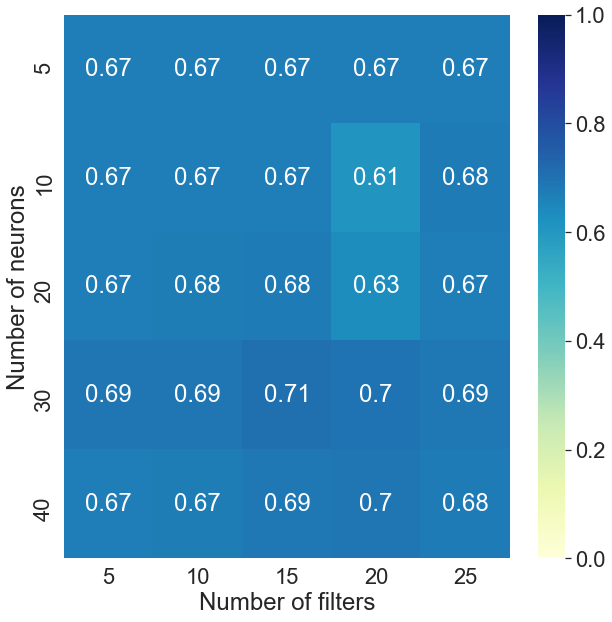

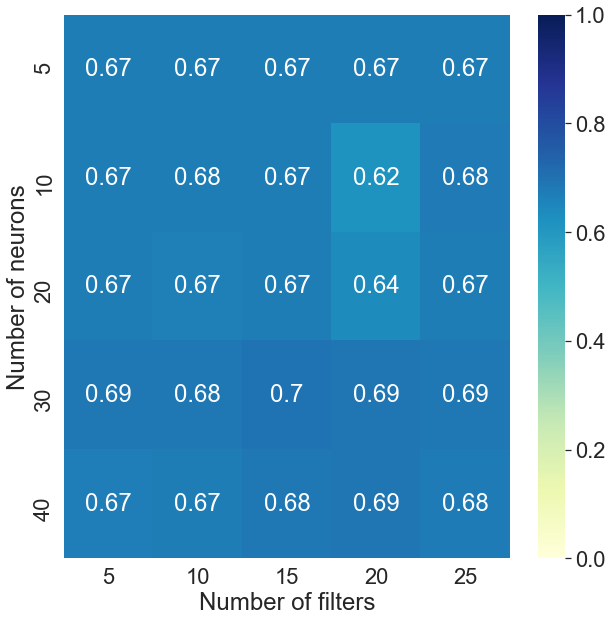

In [86]:
plot_neuronsVSfilters(n_neuron_values,n_filter_values,train_accuracy2,test_accuracy2)

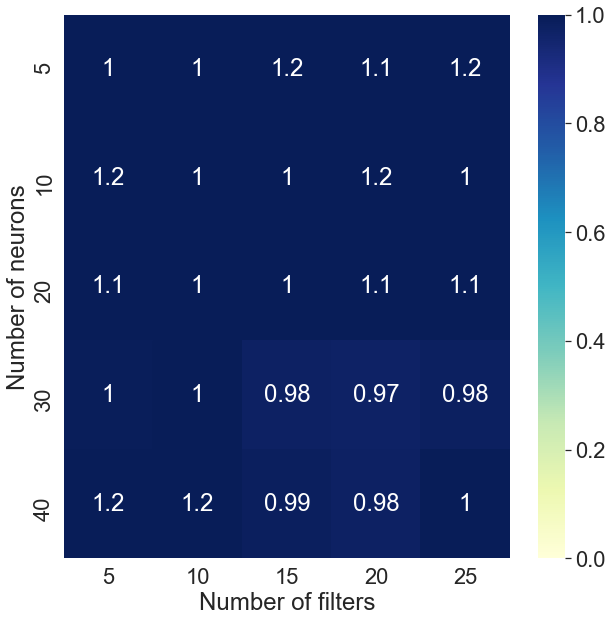

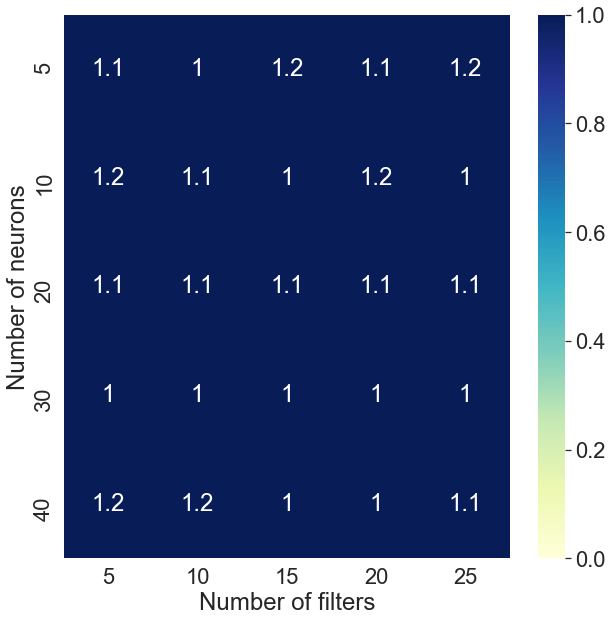

In [87]:
plot_neuronsVSfilters(n_neuron_values,n_filter_values,train_loss,test_loss)

### Confusion Matrix for the best model

In [88]:
# Now we pick the best model and run it for a 1000 epochs
CNN_model = create_convolutional_NN(input_shape, 30, n_categories, eta=0.01, lmbd=0.01, 
                                    n_filters = 15, filter_sizes = receptive_field)
CNN_model.fit(train, train_labels, epochs = 1000, batch_size = batch_size, verbose =1, validation_data = 
              (valid, valid_labels))
print(CNN_model.evaluate(train, train_labels))

Convolutional Neural Network model with the following parameters:
------------------------------------------------------------------
Learning rate eta =  0.01
regularization strength lambda =  0.01

Number of convolutional layers:  1
Number of filters in each convolutional layer:  15
Filter size in each convolutional layer:  3

Number of hidden layers:  1
Nunber of neurons in each hidden layer:  30
Train on 5408 samples, validate on 601 samples
Epoch 1/1000
5408/5408 [==============================] - 14s 3ms/step - loss: 2.0022 - acc: 0.5945 - val_loss: 1.8400 - val_acc: 0.6572
Epoch 2/1000
5408/5408 [==============================] - 1s 269us/step - loss: 1.7916 - acc: 0.6686 - val_loss: 1.7939 - val_acc: 0.6572
Epoch 3/1000
5408/5408 [==============================] - 2s 278us/step - loss: 1.7610 - acc: 0.6686 - val_loss: 1.7646 - val_acc: 0.6572
Epoch 4/1000
5408/5408 [==============================] - 2s 285us/step - loss: 1.7407 - acc: 0.6686 - val_loss: 1.7441 - val_acc: 0.6572


5408/5408 [==============================] - 1s 257us/step - loss: 1.1493 - acc: 0.6712 - val_loss: 1.2799 - val_acc: 0.6572
Epoch 57/1000
5408/5408 [==============================] - 1s 260us/step - loss: 1.1563 - acc: 0.6699 - val_loss: 1.2692 - val_acc: 0.6439
Epoch 58/1000
5408/5408 [==============================] - 1s 257us/step - loss: 1.1418 - acc: 0.6718 - val_loss: 1.2519 - val_acc: 0.6572
Epoch 59/1000
5408/5408 [==============================] - 2s 301us/step - loss: 1.1352 - acc: 0.6714 - val_loss: 1.1738 - val_acc: 0.6589
Epoch 60/1000
5408/5408 [==============================] - 2s 306us/step - loss: 1.1324 - acc: 0.6733 - val_loss: 1.1419 - val_acc: 0.6656
Epoch 61/1000
5408/5408 [==============================] - 2s 331us/step - loss: 1.1280 - acc: 0.6712 - val_loss: 1.1765 - val_acc: 0.6572
Epoch 62/1000
5408/5408 [==============================] - 2s 300us/step - loss: 1.1124 - acc: 0.6746 - val_loss: 1.1862 - val_acc: 0.6589
Epoch 63/1000
5408/5408 [================

5408/5408 [==============================] - 2s 296us/step - loss: 0.9812 - acc: 0.6882 - val_loss: 1.1072 - val_acc: 0.6622
Epoch 115/1000
5408/5408 [==============================] - 1s 254us/step - loss: 0.9670 - acc: 0.6916 - val_loss: 1.0943 - val_acc: 0.6606
Epoch 116/1000
5408/5408 [==============================] - 1s 244us/step - loss: 0.9635 - acc: 0.6940 - val_loss: 1.0077 - val_acc: 0.6739
Epoch 117/1000
5408/5408 [==============================] - 1s 247us/step - loss: 0.9630 - acc: 0.6897 - val_loss: 1.0029 - val_acc: 0.6739
Epoch 118/1000
5408/5408 [==============================] - 1s 247us/step - loss: 0.9619 - acc: 0.6918 - val_loss: 1.0070 - val_acc: 0.6689
Epoch 119/1000
5408/5408 [==============================] - 1s 248us/step - loss: 0.9609 - acc: 0.6906 - val_loss: 1.0194 - val_acc: 0.6755
Epoch 120/1000
5408/5408 [==============================] - 1s 241us/step - loss: 0.9653 - acc: 0.6884 - val_loss: 0.9796 - val_acc: 0.6705
Epoch 121/1000
5408/5408 [=========

5408/5408 [==============================] - 1s 245us/step - loss: 0.9095 - acc: 0.6958 - val_loss: 0.9943 - val_acc: 0.6822
Epoch 173/1000
5408/5408 [==============================] - 1s 254us/step - loss: 0.9120 - acc: 0.6958 - val_loss: 1.0287 - val_acc: 0.6423
Epoch 174/1000
5408/5408 [==============================] - 1s 251us/step - loss: 0.9101 - acc: 0.6960 - val_loss: 0.9880 - val_acc: 0.6606
Epoch 175/1000
5408/5408 [==============================] - 1s 256us/step - loss: 0.9072 - acc: 0.6966 - val_loss: 0.9270 - val_acc: 0.6855
Epoch 176/1000
5408/5408 [==============================] - 1s 271us/step - loss: 0.8980 - acc: 0.6990 - val_loss: 1.1399 - val_acc: 0.6589
Epoch 177/1000
5408/5408 [==============================] - 2s 305us/step - loss: 0.9121 - acc: 0.6967 - val_loss: 1.0138 - val_acc: 0.6656
Epoch 178/1000
5408/5408 [==============================] - 2s 278us/step - loss: 0.9049 - acc: 0.6979 - val_loss: 0.9610 - val_acc: 0.6656
Epoch 179/1000
5408/5408 [=========

5408/5408 [==============================] - 1s 254us/step - loss: 0.8715 - acc: 0.7182 - val_loss: 0.9106 - val_acc: 0.7155
Epoch 231/1000
5408/5408 [==============================] - 1s 247us/step - loss: 0.8633 - acc: 0.7165 - val_loss: 0.9801 - val_acc: 0.6705
Epoch 232/1000
5408/5408 [==============================] - 1s 245us/step - loss: 0.8636 - acc: 0.7200 - val_loss: 0.9311 - val_acc: 0.6955
Epoch 233/1000
5408/5408 [==============================] - 1s 257us/step - loss: 0.8539 - acc: 0.7260 - val_loss: 1.0828 - val_acc: 0.6240
Epoch 234/1000
5408/5408 [==============================] - 1s 256us/step - loss: 0.9001 - acc: 0.7051 - val_loss: 0.9660 - val_acc: 0.6872
Epoch 235/1000
5408/5408 [==============================] - 1s 254us/step - loss: 0.8573 - acc: 0.7163 - val_loss: 0.9401 - val_acc: 0.6755
Epoch 236/1000
5408/5408 [==============================] - 1s 254us/step - loss: 0.8598 - acc: 0.7219 - val_loss: 1.0036 - val_acc: 0.6606
Epoch 237/1000
5408/5408 [=========

5408/5408 [==============================] - 1s 273us/step - loss: 0.8490 - acc: 0.7269 - val_loss: 0.9289 - val_acc: 0.6955
Epoch 289/1000
5408/5408 [==============================] - 1s 270us/step - loss: 0.8402 - acc: 0.7319 - val_loss: 0.9490 - val_acc: 0.6722
Epoch 290/1000
5408/5408 [==============================] - 1s 263us/step - loss: 0.8494 - acc: 0.7261 - val_loss: 1.2776 - val_acc: 0.6622
Epoch 291/1000
5408/5408 [==============================] - 1s 263us/step - loss: 0.8548 - acc: 0.7224 - val_loss: 1.0430 - val_acc: 0.6173
Epoch 292/1000
5408/5408 [==============================] - 1s 257us/step - loss: 0.8490 - acc: 0.7254 - val_loss: 1.0133 - val_acc: 0.6373
Epoch 293/1000
5408/5408 [==============================] - 1s 260us/step - loss: 0.8415 - acc: 0.7249 - val_loss: 0.9450 - val_acc: 0.6872
Epoch 294/1000
5408/5408 [==============================] - 1s 260us/step - loss: 0.8447 - acc: 0.7276 - val_loss: 0.9808 - val_acc: 0.6905
Epoch 295/1000
5408/5408 [=========

5408/5408 [==============================] - 2s 291us/step - loss: 0.8355 - acc: 0.7322 - val_loss: 0.9304 - val_acc: 0.7138
Epoch 347/1000
5408/5408 [==============================] - 2s 284us/step - loss: 0.8336 - acc: 0.7376 - val_loss: 1.1341 - val_acc: 0.6689
Epoch 348/1000
5408/5408 [==============================] - 2s 287us/step - loss: 0.8557 - acc: 0.7271 - val_loss: 0.8870 - val_acc: 0.7171
Epoch 349/1000
5408/5408 [==============================] - 2s 297us/step - loss: 0.8367 - acc: 0.7306 - val_loss: 1.0921 - val_acc: 0.6656
Epoch 350/1000
5408/5408 [==============================] - 2s 300us/step - loss: 0.8450 - acc: 0.7289 - val_loss: 0.8711 - val_acc: 0.7338
Epoch 351/1000
5408/5408 [==============================] - 2s 299us/step - loss: 0.8374 - acc: 0.7322 - val_loss: 0.9079 - val_acc: 0.7038
Epoch 352/1000
5408/5408 [==============================] - 2s 290us/step - loss: 0.8433 - acc: 0.7306 - val_loss: 1.0325 - val_acc: 0.6839
Epoch 353/1000
5408/5408 [=========

5408/5408 [==============================] - 1s 264us/step - loss: 0.8380 - acc: 0.7400 - val_loss: 0.9416 - val_acc: 0.7022
Epoch 405/1000
5408/5408 [==============================] - 1s 263us/step - loss: 0.8347 - acc: 0.7335 - val_loss: 1.1686 - val_acc: 0.6639
Epoch 406/1000
5408/5408 [==============================] - 1s 254us/step - loss: 0.8529 - acc: 0.7308 - val_loss: 1.0776 - val_acc: 0.6473
Epoch 407/1000
5408/5408 [==============================] - 1s 260us/step - loss: 0.8406 - acc: 0.7330 - val_loss: 0.9311 - val_acc: 0.6938
Epoch 408/1000
5408/5408 [==============================] - 1s 253us/step - loss: 0.8342 - acc: 0.7363 - val_loss: 0.9444 - val_acc: 0.7038
Epoch 409/1000
5408/5408 [==============================] - 1s 267us/step - loss: 0.8449 - acc: 0.7322 - val_loss: 0.9599 - val_acc: 0.6889
Epoch 410/1000
5408/5408 [==============================] - 2s 295us/step - loss: 0.8331 - acc: 0.7369 - val_loss: 0.9994 - val_acc: 0.6789
Epoch 411/1000
5408/5408 [=========

5408/5408 [==============================] - 1s 272us/step - loss: 0.8482 - acc: 0.7380 - val_loss: 0.9703 - val_acc: 0.6905
Epoch 463/1000
5408/5408 [==============================] - 1s 251us/step - loss: 0.8262 - acc: 0.7409 - val_loss: 1.4797 - val_acc: 0.4992
Epoch 464/1000
5408/5408 [==============================] - 1s 260us/step - loss: 0.8687 - acc: 0.7228 - val_loss: 1.0270 - val_acc: 0.6223
Epoch 465/1000
5408/5408 [==============================] - 1s 260us/step - loss: 0.8427 - acc: 0.7347 - val_loss: 1.3968 - val_acc: 0.5458
Epoch 466/1000
5408/5408 [==============================] - 1s 260us/step - loss: 0.8646 - acc: 0.7271 - val_loss: 0.9819 - val_acc: 0.6872
Epoch 467/1000
5408/5408 [==============================] - 1s 263us/step - loss: 0.8301 - acc: 0.7409 - val_loss: 0.9531 - val_acc: 0.6922
Epoch 468/1000
5408/5408 [==============================] - 1s 265us/step - loss: 0.8366 - acc: 0.7376 - val_loss: 0.9096 - val_acc: 0.7138
Epoch 469/1000
5408/5408 [=========

5408/5408 [==============================] - 1s 266us/step - loss: 0.8417 - acc: 0.7367 - val_loss: 0.9022 - val_acc: 0.7088
Epoch 521/1000
5408/5408 [==============================] - 1s 251us/step - loss: 0.8405 - acc: 0.7326 - val_loss: 0.9105 - val_acc: 0.7088
Epoch 522/1000
5408/5408 [==============================] - 1s 263us/step - loss: 0.8538 - acc: 0.7284 - val_loss: 1.0949 - val_acc: 0.6805
Epoch 523/1000
5408/5408 [==============================] - 1s 257us/step - loss: 0.8483 - acc: 0.7343 - val_loss: 0.9629 - val_acc: 0.6972
Epoch 524/1000
5408/5408 [==============================] - 1s 257us/step - loss: 0.8467 - acc: 0.7306 - val_loss: 0.9282 - val_acc: 0.7072
Epoch 525/1000
5408/5408 [==============================] - 1s 257us/step - loss: 0.8524 - acc: 0.7319 - val_loss: 1.0711 - val_acc: 0.6639
Epoch 526/1000
5408/5408 [==============================] - 1s 260us/step - loss: 0.8543 - acc: 0.7284 - val_loss: 0.9042 - val_acc: 0.7105
Epoch 527/1000
5408/5408 [=========

Epoch 578/1000
5408/5408 [==============================] - 1s 263us/step - loss: 0.8277 - acc: 0.7415 - val_loss: 0.9331 - val_acc: 0.7138
Epoch 579/1000
5408/5408 [==============================] - 2s 283us/step - loss: 0.8393 - acc: 0.7352 - val_loss: 1.0184 - val_acc: 0.6772
Epoch 580/1000
5408/5408 [==============================] - 1s 265us/step - loss: 0.8452 - acc: 0.7322 - val_loss: 0.9046 - val_acc: 0.7105
Epoch 581/1000
5408/5408 [==============================] - 1s 250us/step - loss: 0.8328 - acc: 0.7404 - val_loss: 0.9386 - val_acc: 0.6905
Epoch 582/1000
5408/5408 [==============================] - 1s 248us/step - loss: 0.8378 - acc: 0.7354 - val_loss: 0.9819 - val_acc: 0.6955
Epoch 583/1000
5408/5408 [==============================] - 1s 247us/step - loss: 0.8336 - acc: 0.7367 - val_loss: 0.9729 - val_acc: 0.6889
Epoch 584/1000
5408/5408 [==============================] - 1s 248us/step - loss: 0.8340 - acc: 0.7393 - val_loss: 1.0876 - val_acc: 0.6290
Epoch 585/1000
5408/

5408/5408 [==============================] - 1s 260us/step - loss: 0.8245 - acc: 0.7426 - val_loss: 1.0806 - val_acc: 0.6240
Epoch 637/1000
5408/5408 [==============================] - 1s 272us/step - loss: 0.8358 - acc: 0.7384 - val_loss: 0.9313 - val_acc: 0.7138
Epoch 638/1000
5408/5408 [==============================] - 1s 245us/step - loss: 0.8360 - acc: 0.7406 - val_loss: 1.0056 - val_acc: 0.6839
Epoch 639/1000
5408/5408 [==============================] - 1s 241us/step - loss: 0.8252 - acc: 0.7420 - val_loss: 0.9826 - val_acc: 0.6739
Epoch 640/1000
5408/5408 [==============================] - 1s 257us/step - loss: 0.8335 - acc: 0.7398 - val_loss: 0.9295 - val_acc: 0.7055
Epoch 641/1000
5408/5408 [==============================] - 1s 247us/step - loss: 0.8232 - acc: 0.7411 - val_loss: 1.1298 - val_acc: 0.6639
Epoch 642/1000
5408/5408 [==============================] - 1s 241us/step - loss: 0.8307 - acc: 0.7382 - val_loss: 0.9059 - val_acc: 0.7205
Epoch 643/1000
5408/5408 [=========

5408/5408 [==============================] - 2s 287us/step - loss: 0.8314 - acc: 0.7430 - val_loss: 1.3011 - val_acc: 0.5607
Epoch 695/1000
5408/5408 [==============================] - 1s 241us/step - loss: 0.8529 - acc: 0.7311 - val_loss: 0.9378 - val_acc: 0.7105
Epoch 696/1000
5408/5408 [==============================] - 1s 244us/step - loss: 0.8339 - acc: 0.7395 - val_loss: 0.9421 - val_acc: 0.7121
Epoch 697/1000
5408/5408 [==============================] - 1s 250us/step - loss: 0.8315 - acc: 0.7387 - val_loss: 1.0791 - val_acc: 0.6156
Epoch 698/1000
5408/5408 [==============================] - 1s 238us/step - loss: 0.8476 - acc: 0.7295 - val_loss: 1.1721 - val_acc: 0.6839
Epoch 699/1000
5408/5408 [==============================] - 1s 244us/step - loss: 0.8494 - acc: 0.7358 - val_loss: 0.9828 - val_acc: 0.6889
Epoch 700/1000
5408/5408 [==============================] - 1s 235us/step - loss: 0.8473 - acc: 0.7382 - val_loss: 1.1298 - val_acc: 0.5840
Epoch 701/1000
5408/5408 [=========

5408/5408 [==============================] - 1s 253us/step - loss: 0.8301 - acc: 0.7428 - val_loss: 2.2236 - val_acc: 0.1614
Epoch 753/1000
5408/5408 [==============================] - 1s 263us/step - loss: 0.9017 - acc: 0.7139 - val_loss: 0.9647 - val_acc: 0.7121
Epoch 754/1000
5408/5408 [==============================] - 1s 245us/step - loss: 0.8466 - acc: 0.7330 - val_loss: 0.9548 - val_acc: 0.6988
Epoch 755/1000
5408/5408 [==============================] - 1s 244us/step - loss: 0.8346 - acc: 0.7430 - val_loss: 0.9586 - val_acc: 0.7171
Epoch 756/1000
5408/5408 [==============================] - 1s 245us/step - loss: 0.8282 - acc: 0.7432 - val_loss: 0.9771 - val_acc: 0.6922
Epoch 757/1000
5408/5408 [==============================] - 1s 250us/step - loss: 0.8295 - acc: 0.7433 - val_loss: 0.9879 - val_acc: 0.7055
Epoch 758/1000
5408/5408 [==============================] - 1s 248us/step - loss: 0.8339 - acc: 0.7395 - val_loss: 0.9062 - val_acc: 0.7255
Epoch 759/1000
5408/5408 [=========

5408/5408 [==============================] - 1s 248us/step - loss: 0.8314 - acc: 0.7424 - val_loss: 0.9482 - val_acc: 0.7105
Epoch 811/1000
5408/5408 [==============================] - 1s 241us/step - loss: 0.8287 - acc: 0.7443 - val_loss: 1.0043 - val_acc: 0.6922
Epoch 812/1000
5408/5408 [==============================] - 1s 247us/step - loss: 0.8360 - acc: 0.7413 - val_loss: 0.9308 - val_acc: 0.7155
Epoch 813/1000
5408/5408 [==============================] - 1s 244us/step - loss: 0.8240 - acc: 0.7445 - val_loss: 0.9903 - val_acc: 0.7155
Epoch 814/1000
5408/5408 [==============================] - 1s 244us/step - loss: 0.8307 - acc: 0.7426 - val_loss: 1.0174 - val_acc: 0.6822
Epoch 815/1000
5408/5408 [==============================] - 1s 247us/step - loss: 0.8268 - acc: 0.7474 - val_loss: 0.9515 - val_acc: 0.7005
Epoch 816/1000
5408/5408 [==============================] - 1s 244us/step - loss: 0.8329 - acc: 0.7435 - val_loss: 1.0196 - val_acc: 0.7005
Epoch 817/1000
5408/5408 [=========

5408/5408 [==============================] - ETA: 0s - loss: 0.8434 - acc: 0.740 - 1s 245us/step - loss: 0.8411 - acc: 0.7415 - val_loss: 1.1011 - val_acc: 0.5874
Epoch 869/1000
5408/5408 [==============================] - 1s 241us/step - loss: 0.8242 - acc: 0.7465 - val_loss: 1.2120 - val_acc: 0.6306
Epoch 870/1000
5408/5408 [==============================] - 1s 247us/step - loss: 0.8414 - acc: 0.7384 - val_loss: 0.9377 - val_acc: 0.7155
Epoch 871/1000
5408/5408 [==============================] - 1s 245us/step - loss: 0.8245 - acc: 0.7452 - val_loss: 1.0890 - val_acc: 0.6672
Epoch 872/1000
5408/5408 [==============================] - 1s 247us/step - loss: 0.8239 - acc: 0.7478 - val_loss: 0.9253 - val_acc: 0.7171
Epoch 873/1000
5408/5408 [==============================] - 1s 250us/step - loss: 0.8237 - acc: 0.7480 - val_loss: 0.9781 - val_acc: 0.6955
Epoch 874/1000
5408/5408 [==============================] - 1s 251us/step - loss: 0.8268 - acc: 0.7489 - val_loss: 1.1490 - val_acc: 0.66

5408/5408 [==============================] - 1s 267us/step - loss: 0.8264 - acc: 0.7483 - val_loss: 0.9848 - val_acc: 0.7105
Epoch 927/1000
5408/5408 [==============================] - 2s 296us/step - loss: 0.8204 - acc: 0.7504 - val_loss: 0.9943 - val_acc: 0.6988
Epoch 928/1000
5408/5408 [==============================] - 2s 297us/step - loss: 0.8327 - acc: 0.7404 - val_loss: 1.2819 - val_acc: 0.5874
Epoch 929/1000
5408/5408 [==============================] - 2s 297us/step - loss: 0.8418 - acc: 0.7389 - val_loss: 0.9411 - val_acc: 0.6988
Epoch 930/1000
5408/5408 [==============================] - 2s 281us/step - loss: 0.8258 - acc: 0.7493 - val_loss: 0.9237 - val_acc: 0.7205
Epoch 931/1000
5408/5408 [==============================] - 2s 289us/step - loss: 0.8240 - acc: 0.7476 - val_loss: 0.9436 - val_acc: 0.7155
Epoch 932/1000
5408/5408 [==============================] - 1s 271us/step - loss: 0.8216 - acc: 0.7513 - val_loss: 0.9278 - val_acc: 0.7221
Epoch 933/1000
5408/5408 [=========

5408/5408 [==============================] - 2s 288us/step - loss: 0.8335 - acc: 0.7424 - val_loss: 0.9488 - val_acc: 0.7072
Epoch 985/1000
5408/5408 [==============================] - 2s 294us/step - loss: 0.8322 - acc: 0.7469 - val_loss: 0.9802 - val_acc: 0.7138
Epoch 986/1000
5408/5408 [==============================] - 2s 283us/step - loss: 0.8275 - acc: 0.7469 - val_loss: 1.0001 - val_acc: 0.6656
Epoch 987/1000
5408/5408 [==============================] - 2s 285us/step - loss: 0.8285 - acc: 0.7483 - val_loss: 0.9368 - val_acc: 0.7088s - loss: 0.8343 - acc:
Epoch 988/1000
5408/5408 [==============================] - 2s 287us/step - loss: 0.8220 - acc: 0.7480 - val_loss: 0.9504 - val_acc: 0.6938
Epoch 989/1000
5408/5408 [==============================] - 2s 278us/step - loss: 0.8209 - acc: 0.7491 - val_loss: 1.0608 - val_acc: 0.6855
Epoch 990/1000
5408/5408 [==============================] - 2s 285us/step - loss: 0.8330 - acc: 0.7461 - val_loss: 0.9427 - val_acc: 0.7022
Epoch 991/10

In [106]:
np.set_printoptions(precision=3)

# Predict the values from the validation dataset
pred_train = CNN_model.predict(train)
pred_test = CNN_model.predict(test)

# Convert predicted classes to one hot vectors 
pred_train = np.argmax(pred_train,axis = 1)
pred_test = np.argmax(pred_test,axis = 1)

# Convert train and test observations to one hot vectors
converted_train_values = np.argmax(train_labels, axis = 1)
converted_test_values = np.argmax(test_labels, axis = 1)

In [107]:
# Rearranging values, in order to correctly correspond to the confusion matrix axis
print(legend)
print(pred_train)
for i in range(len(pred_train)):
    pred_train[i] = legend[pred_train[i]]
    converted_train_values[i] = legend[converted_train_values[i]]

for i in range(len(pred_test)):
    pred_test[i] = legend[pred_test[i]]
    converted_test_values[i] = legend[converted_test_values[i]]

[2, 4, 3, 6, 5, 1, 0]
[1 1 1 ... 3 1 1]


Text(63.7, 0.5, 'predicted label')

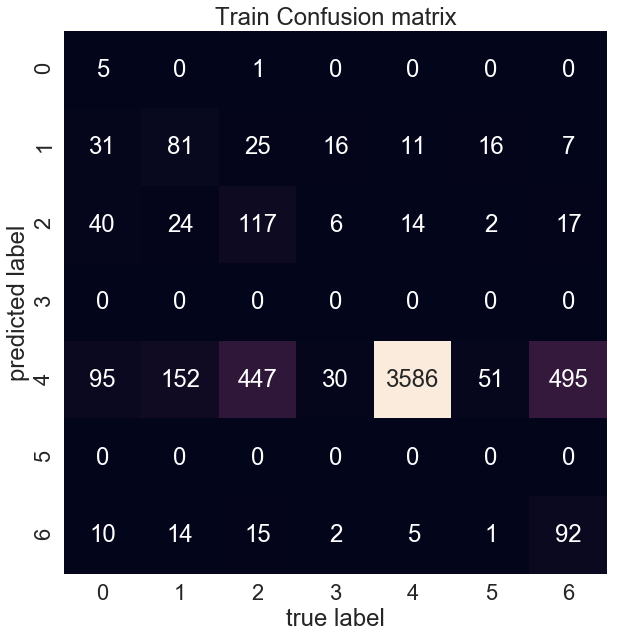

In [108]:
# computing the confusion matrix
mat = confusion_matrix(converted_train_values, pred_train)

# plotting confusion matrix
%matplotlib inline
plt.figure(figsize=(10,10))
sns.set(font_scale=2)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False) 

plt.title('Train Confusion matrix')
plt.xlabel('true label')
plt.ylabel('predicted label')

#fig1.show()
#plt.savefig('confuseMat_train.png')

Text(63.7, 0.5, 'predicted label')

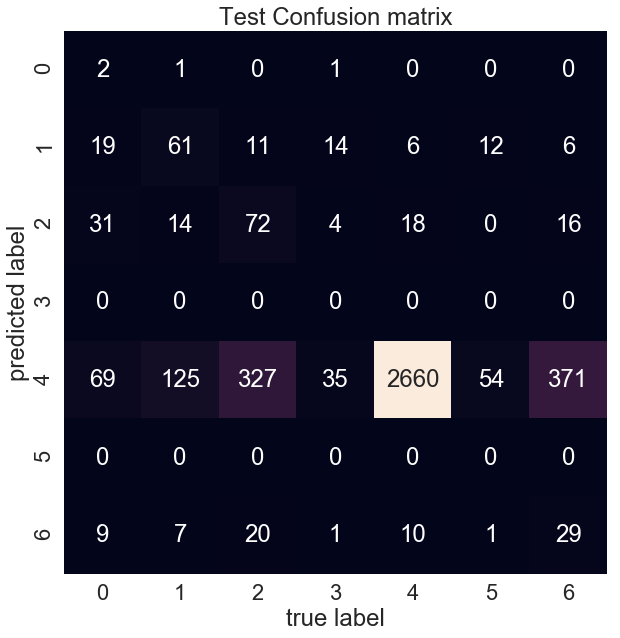

In [109]:
# computing the confusion matrix
mat = confusion_matrix(converted_test_values, pred_test)

# plotting confusion matrix
plt.figure(figsize=(10,10))
sns.set(font_scale=2)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False) 

plt.title('Test Confusion matrix')
plt.xlabel('true label')
plt.ylabel('predicted label')

#fig1.show()
#plt.savefig('confuseMat_test.png')